# Neural Networks and Learning Machines
## ANN 1 - Training, validation, and testing
This exercise is split into three different parts. First, you will test some simple machine learning models that aren't neural networks. Secondly, you will implement and train a 2 layer neural network using a high level library, [pytorch](https://pytorch.org/). Finally, you will create the neural network, the forward pass and the backward pass from scratch using numpy. The data which will be used is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which contains handwritten numbers from 0-9. Examples can be seen in the image below.

![MNIST digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Literature
Before starting with the implementation you should familiarize yourself with relevant sections from the [course book](https://www.deeplearningbook.org/). This will help you understand the theory behind neural networks and what mathematical formulas are important for the task. The lectures has touched on most of these concepts too. Below will be a list of recommended sections from the book. If you feel you are already familiarize with the contents of the section, feel free to skip it.

* Chapter 5 - Machine learning basics
    - Section 5.1 - Explains the basics of what we mean by learning and what supervised learning is (including linear regression).
    - Section 5.2 - Talks about generalization, the generalization gap and under/overfitting.
    - Section 5.3 - Validation and validation set.
* Chapter 6 - Deep feedforward networks
    - Section 6.0 - Discusses what do we mean by feedfoward networks and terminology such as input layer, output layer and hidden layer.
    - Section 6.2 - Discusses what gradient based learning is and what cost functions are.
    - Section 6.5 - Explains back propagation. Important here are the formulas 6.49 - 6.52.

## Examination

### Part 1

* Try 4 machine learning models that are not Neural Networks using scikit-learn: decision tree, linear regression, logistic regression, and Support-Vector Machine (SVM)
* Write a short description of the main difference between linear and logistic regression in the provided cell.

### Part 2
* Implementation of a 2 layer NN (very similar to ex0)
* Training of this 2 layer NN (once again, very similar to ex0)
* Validation of the network during training (requires splitting the training set)
    - Save the model which performs the best on the validation data
* Graph the training loss vs validation loss
* At least 85% accuracy on the test data (remember to load the best performing model before performing the accuracy test)

### Part 3
* Implementation of a 2 layer NN using numpy
* Training and validation of the 2 layer NN
    - Once again, save the best performing model (can be done in memory)
* Graph the training vs validation loss
* At least 50% accuracy on the validation data (can be hard to get high accuracy)

# MNIST dataset preparation
We will start by importing the packages we'll be using as well as downloading and preparing the data such that it is usable for our purposes.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import numpy
import copy

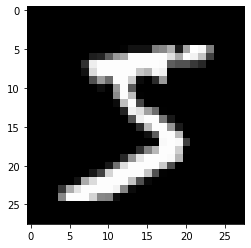

In [ ]:
# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
## IN PART 2 YOU MAY WANT TO ADD A WAY TO SPLIT THE DATASET HERE##


mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

# Part 1

## Test some non-neural network machine learning models

Neural Networks are just a small part of the large field of machine learning. Many machine learning models exist that does not fall under the umbrella of neural networks and it's good to be familiar with some of them.
In this part of the exercise you will test decision tree, linear regression, logistic regression, and Support-Vector Machine (SVM) models using their implementations from the scikit-learn package.

To start with let's have quick walk-through of the methods we'll be using:

**Decision trees** work by inserting a data point into the root of the tree and then by comparing different features of the data point it is sent to the next step in the tree until it reaches a leaf node which contains the final prediction for the data point. There are many different ways to create a tree to fit some training set but training procedures often follow a divide-and-conquer strategy:
* Find an attribute that splits the different classes or labels of the training data as neatly as possible and create a node that splits using that attribute.
* Repeat the procedure to create the subnodes using the training data that subnode would encounter.
* This is repeated for each until either a performance requirement or a certain depth is reached at which point each leaf node is assigned as a predictor for the highest liklihood label to reach that node.

An example of a short decision tree can be found in the image below.
![Decision Tree](https://miro.medium.com/max/720/1*YTg8AE3nAsbfn-elHuJNIA.jpeg)

**Linear regression, logistic regression, and SVM** are all versions of linear models. Linear models work by, for training data in some hyper-space (a space with N dimensions) learning a hyperplane (a plane with N-1 dimensions) that fits the data best. In the case of binary classification the goal is to have as many samples of each class on separate sides of the plane. The calculation of a linear model can be described by the vector equation below, where *x* is the data point and **w** and b are learned parameters, and f() is an activation function.

\begin{equation*}
y = f(\mathbf{w}\mathit{x} + b)
\end{equation*}

As you can see this is identical to the equation of an artificial neuron, and when extended to handle multiple outputs (by using  matrices for **w** and b instead of vectors) become equivalent to a single-layer ANN.
However, even though prediction, in the simplest case, is equivalent to a single-layer neural network there are many different linear models that vary in different ways. Common things to change is activation function, learning method, optimization criteria, or the addition of kernel functions to bring complex datasets into higher dimensional spaces where it's easier to linearly separate. So, while it may seem pointless to use a linear model when they seem equivalent to a single-layer neural network, some models come with advantages that neural network have difficulty replicating. A common advantage is that while neural networks often needs to be trained using backpropagation, linear models are well-studied with many different optimization short-cuts and techniques0.

As you will see when running the models below, these models all get impressive results on the dataset, despite their apparent simplicity. To test these models we're using their implementation from the Python library [Scikit-Learn](https://scikit-learn.org/stable/index.html) which contains implementations of a host of different machine learning models and methods. While knowing a Scikit-Learn is not mandatory for this Exercise, it's well worth having a look at for anyone interested in non-neural network machine learning (though it does contain some neural networks as well).

**Exercise:** Look through the code below and run it to get the results of the different machine learning models (You might get some warnings, but don't worry about those). Then read up on linear and logistic regression and write a short description of their difference in the cell below

In [ ]:
# Since Scikit-Learn uses Numpy we need to transform all our data to numpy arrays,
# which can be done by Pytorch's .numpy() function
X_train = mnist_train.data.view(-1, 784).numpy()
y_train = mnist_train.targets.numpy()
y_10_train = to_onehot(mnist_train.targets).detach().numpy()

X_test = mnist_test.data.view(-1, 784).numpy()
y_test = mnist_test.targets.numpy()

# Many machine learning models in Sciki-Learn work better if the data has been normalized to mean 0 and Std. Dev. 1
# which can be done with Scikit-Learn's StandardScaler
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# We make a function for handling the training and testing of a given Scikit-Learn classifier
def train_and_test(classifier, train_data, train_labels, test_data, test_labels, onehot_output=False):
    # Trains the classifier witht he given data and labels
    classifier.fit(train_data, train_labels)
    # Uses the trained classifier to predict the classes of the test set
    predictions = classifier.predict(test_data)
    # Some models output with predictions for each class rather than one index for the predicted class
    if onehot_output:
        predictions = numpy.argmax(predictions, axis=1)
    # By comparing the actual labels to the predictions we can calculate the accuracy of the classifier
    return accuracy_score(test_labels, predictions)


# We create the classifiers to test
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Linear Regression": LinearRegression(),
    # We use the SGDClassifier (which trains a linear model using SGD) to implement Logistic Regression and SVM
    "Logistic Regression": SGDClassifier(loss='log', max_iter=100),
    "SVM": SGDClassifier(loss='hinge', max_iter=100)
}


# We train and test each classifier
for classifier in classifiers:
    onehot_output = classifier == "Linear Regression"
    y = y_10_train if onehot_output else y_train
    result = train_and_test(classifiers[classifier], X_train, y, X_test, y_test, onehot_output=onehot_output)
    print("Classifier {} got {}% accuracy on the test set".format(classifier, result*100))


Classifier Decision Tree got 87.87% accuracy on the test set
Classifier Linear Regression got 86.02% accuracy on the test set


C:\Users\pawel\anaconda3\envs\nnml\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Classifier Logistic Regression got 87.47% accuracy on the test set
Classifier SVM got 89.9% accuracy on the test set


C:\Users\pawel\anaconda3\envs\nnml\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


#### Exercise: Explain in three or four sentences the main difference between linear- and logistic regression.

Linear regression predicts the value of continuous variables while Logistic Regression predicts discrete variables. This means that Linear regression is used to solve Regression problems while Logistical regression is used for solving classification problems. The methods for calculating loss function differes, where for linear regression you use the mean squared error but for logistical regression you use maximum likelyhood estimation (e.g. ReLU vs sigmoid)

# Part 2

## Implement a classifier using pytorch

Given the code below, your knowledge from the literature, lectures, and exercise 0. Implement a 2 layer neural network using pytorch as well as the procedure for training, validation, and testing.

The training should include both training and validation. As such you need to split the training data into a training set (for which the error is backpropagated to update the parameters) and a validation set (which will not be used to directly update the model parameters, and instead be used to keep track of how good the model is at unseen data). The weights of the model which performs the best on the validation det should be stored and then be used for the final check on the test set. Validation sets are often created by taking a fraction of the training data (often, but not always, around 20%) at random. In Pytorch you might want to use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)() for this. Using random split would require you to edit the way the Dataloaders are created. If you edit the data collection provided, make sure you retain the old DataLoaders as they are used in part 1.

You are free to choose any optimizer and loss function. Just note that some loss functions require the labels to be 1-hot encoded. As you will not use convolutional layers for this exercise (later in the course), the input needs to be changed to a 1d tensor (see [view](https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view)()).

**Exercise:** Implement a 2-layer NN as well as the procedures for training, validation, and testing. You should use the network from the epoch with best validation score on the test set which should achive at least 85% accuracy.

***Remember*** to run all your code before grading so the TA doesn't have to wait around for long training runs. Plot the training and validation losses for each epoch.

*Hint:* Validation and Testing loops are very similar to training except they don't use backpropagation. Additionally testing should only be performed once, while validation should be performed continually to make sure training is proceeding as intended and to save the parameters of the best epoch.

*Hint:* Storing the best model is a bit more difficult than just assigning it to a variable as this only means you have to variables pointing to the same network, not one containing the best one and one containing the current. Instead you ned to make a copy of the network which can be achived with [deepcopy](https://docs.python.org/3/library/copy.html)(). Other ways to store models include saving them as a file which can be done with [torch.save](https://pytorch.org/tutorials/beginner/saving_loading_models.html)().

*Hint:* Everytime you train a network random initialization and random mini-batches means that you get networks with different performance. Sometimes just running the training again can be enough to get a better result. However, if you do this too many times you run the risk of training (overfitting) on the test set.

Predicting with the randomly initialized network before training to see what happens


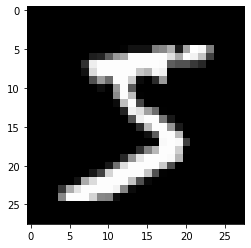

Prediction: 5 - Actual: 5


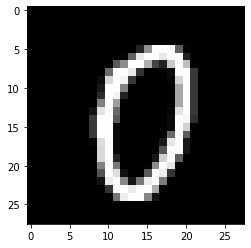

Prediction: 5 - Actual: 0


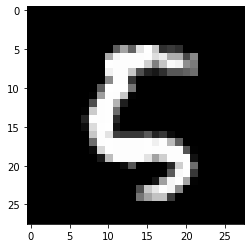

Prediction: 5 - Actual: 5
Prediction: 5 - Actual: 7image:0
Prediction: 8 - Actual: 2image:1
Prediction: 5 - Actual: 1image:2
Prediction: 6 - Actual: 0image:3
Prediction: 5 - Actual: 4image:4
Prediction: 9 - Actual: 1image:5
Prediction: 8 - Actual: 4image:6
Prediction: 5 - Actual: 9image:7
Prediction: 5 - Actual: 5image:8
Prediction: 9 - Actual: 9image:9
Prediction: 5 - Actual: 0image:10
Prediction: 9 - Actual: 6image:11
Prediction: 4 - Actual: 9image:12
Prediction: 5 - Actual: 0image:13
Prediction: 4 - Actual: 1image:14
Prediction: 5 - Actual: 5image:15
Prediction: 5 - Actual: 9image:16
Prediction: 5 - Actual: 7image:17
Prediction: 9 - Actual: 3image:18
Prediction: 5 - Actual: 4image:19
Prediction: 9 - Actual: 9image:20
Prediction: 5 - Actual: 6image:21
Prediction: 5 - Actual: 6image:22
Prediction: 8 - Actual: 5image:23
Prediction: 5 - Actual: 4image:24
Prediction: 5 - Actual: 0image:25
Prediction: 5 - Actual: 7image:26
Prediction: 5 - Actual: 4image:27
Prediction: 5 - Actual: 0image:2

Prediction: 9 - Actual: 5image:478
Prediction: 8 - Actual: 9image:479
Prediction: 5 - Actual: 1image:480
Prediction: 5 - Actual: 9image:481
Prediction: 8 - Actual: 7image:482
Prediction: 8 - Actual: 5image:483
Prediction: 5 - Actual: 4image:484
Prediction: 5 - Actual: 0image:485
Prediction: 9 - Actual: 8image:486
Prediction: 5 - Actual: 9image:487
Prediction: 9 - Actual: 9image:488
Prediction: 5 - Actual: 1image:489
Prediction: 0 - Actual: 0image:490
Prediction: 5 - Actual: 5image:491
Prediction: 5 - Actual: 2image:492
Prediction: 5 - Actual: 3image:493
Prediction: 5 - Actual: 7image:494
Prediction: 9 - Actual: 8image:495
Prediction: 5 - Actual: 9image:496
Prediction: 9 - Actual: 4image:497
Prediction: 5 - Actual: 0image:498
Prediction: 5 - Actual: 6image:499
Prediction: 5 - Actual: 3image:500
Prediction: 5 - Actual: 9image:501
Prediction: 9 - Actual: 5image:502
Prediction: 9 - Actual: 2image:503
Prediction: 9 - Actual: 1image:504
Prediction: 5 - Actual: 3image:505
Prediction: 9 - Actu

Prediction: 5 - Actual: 9image:0
Prediction: 5 - Actual: 0image:1
Prediction: 9 - Actual: 2image:2
Prediction: 5 - Actual: 5image:3
Prediction: 9 - Actual: 1image:4
Prediction: 5 - Actual: 9image:5
Prediction: 5 - Actual: 7image:6
Prediction: 9 - Actual: 8image:7
Prediction: 9 - Actual: 1image:8
Prediction: 5 - Actual: 0image:9
Prediction: 8 - Actual: 4image:10
Prediction: 4 - Actual: 1image:11
Prediction: 5 - Actual: 7image:12
Prediction: 9 - Actual: 9image:13
Prediction: 5 - Actual: 6image:14
Prediction: 5 - Actual: 4image:15
Prediction: 5 - Actual: 2image:16
Prediction: 5 - Actual: 6image:17
Prediction: 5 - Actual: 8image:18
Prediction: 5 - Actual: 1image:19
Prediction: 9 - Actual: 3image:20
Prediction: 5 - Actual: 7image:21
Prediction: 8 - Actual: 5image:22
Prediction: 5 - Actual: 4image:23
Prediction: 5 - Actual: 4image:24
Prediction: 9 - Actual: 1image:25
Prediction: 5 - Actual: 8image:26
Prediction: 9 - Actual: 1image:27
Prediction: 5 - Actual: 3image:28
Prediction: 9 - Actual: 

Prediction: 5 - Actual: 4image:422
Prediction: 5 - Actual: 9image:423
Prediction: 4 - Actual: 1image:424
Prediction: 5 - Actual: 8image:425
Prediction: 9 - Actual: 3image:426
Prediction: 5 - Actual: 4image:427
Prediction: 9 - Actual: 9image:428
Prediction: 5 - Actual: 9image:429
Prediction: 9 - Actual: 1image:430
Prediction: 5 - Actual: 2image:431
Prediction: 9 - Actual: 2image:432
Prediction: 9 - Actual: 8image:433
Prediction: 9 - Actual: 1image:434
Prediction: 8 - Actual: 9image:435
Prediction: 5 - Actual: 6image:436
Prediction: 8 - Actual: 4image:437
Prediction: 5 - Actual: 0image:438
Prediction: 9 - Actual: 9image:439
Prediction: 5 - Actual: 4image:440
Prediction: 9 - Actual: 8image:441
Prediction: 9 - Actual: 3image:442
Prediction: 5 - Actual: 8image:443
Prediction: 8 - Actual: 6image:444
Prediction: 8 - Actual: 0image:445
Prediction: 5 - Actual: 2image:446
Prediction: 5 - Actual: 5image:447
Prediction: 5 - Actual: 1image:448
Prediction: 5 - Actual: 9image:449
Prediction: 8 - Actu

Prediction: 5 - Actual: 4image:978
Prediction: 5 - Actual: 9image:979
Prediction: 5 - Actual: 4image:980
Prediction: 5 - Actual: 6image:981
Prediction: 5 - Actual: 6image:982
Prediction: 9 - Actual: 3image:983
Prediction: 5 - Actual: 2image:984
Prediction: 5 - Actual: 4image:985
Prediction: 9 - Actual: 1image:986
Prediction: 7 - Actual: 0image:987
Prediction: 9 - Actual: 1image:988
Prediction: 9 - Actual: 4image:989
Prediction: 9 - Actual: 6image:990
Prediction: 9 - Actual: 2image:991
Prediction: 9 - Actual: 9image:992
Prediction: 9 - Actual: 1image:993
Prediction: 9 - Actual: 1image:994
Prediction: 5 - Actual: 0image:995
Prediction: 5 - Actual: 6image:996
Prediction: 8 - Actual: 3image:997
Prediction: 5 - Actual: 9image:998
Prediction: 5 - Actual: 5image:999
Prediction: 5 - Actual: 9
Prediction: 5 - Actual: 6image:0
Prediction: 8 - Actual: 5image:1
Prediction: 9 - Actual: 6image:2
Prediction: 9 - Actual: 5image:3
Prediction: 5 - Actual: 8image:4
Prediction: 5 - Actual: 4image:5
Predic

Prediction: 8 - Actual: 3image:551
Prediction: 5 - Actual: 8image:552
Prediction: 9 - Actual: 1image:553
Prediction: 9 - Actual: 5image:554
Prediction: 5 - Actual: 3image:555
Prediction: 5 - Actual: 5image:556
Prediction: 5 - Actual: 0image:557
Prediction: 5 - Actual: 5image:558
Prediction: 5 - Actual: 5image:559
Prediction: 4 - Actual: 3image:560
Prediction: 5 - Actual: 8image:561
Prediction: 9 - Actual: 6image:562
Prediction: 5 - Actual: 7image:563
Prediction: 9 - Actual: 7image:564
Prediction: 5 - Actual: 7image:565
Prediction: 9 - Actual: 3image:566
Prediction: 5 - Actual: 7image:567
Prediction: 8 - Actual: 0image:568
Prediction: 8 - Actual: 5image:569
Prediction: 5 - Actual: 9image:570
Prediction: 5 - Actual: 0image:571
Prediction: 5 - Actual: 2image:572
Prediction: 5 - Actual: 5image:573
Prediction: 5 - Actual: 5image:574
Prediction: 9 - Actual: 3image:575
Prediction: 8 - Actual: 1image:576
Prediction: 5 - Actual: 7image:577
Prediction: 9 - Actual: 7image:578
Prediction: 5 - Actu

Prediction: 5 - Actual: 6image:0
Prediction: 5 - Actual: 9image:1
Prediction: 5 - Actual: 8image:2
Prediction: 9 - Actual: 1image:3
Prediction: 9 - Actual: 2image:4
Prediction: 9 - Actual: 9image:5
Prediction: 5 - Actual: 9image:6
Prediction: 9 - Actual: 5image:7
Prediction: 5 - Actual: 9image:8
Prediction: 5 - Actual: 7image:9
Prediction: 9 - Actual: 3image:10
Prediction: 8 - Actual: 7image:11
Prediction: 9 - Actual: 8image:12
Prediction: 5 - Actual: 0image:13
Prediction: 5 - Actual: 1image:14
Prediction: 9 - Actual: 3image:15
Prediction: 5 - Actual: 0image:16
Prediction: 5 - Actual: 4image:17
Prediction: 7 - Actual: 6image:18
Prediction: 5 - Actual: 1image:19
Prediction: 8 - Actual: 0image:20
Prediction: 5 - Actual: 2image:21
Prediction: 8 - Actual: 5image:22
Prediction: 5 - Actual: 8image:23
Prediction: 8 - Actual: 4image:24
Prediction: 5 - Actual: 4image:25
Prediction: 9 - Actual: 1image:26
Prediction: 5 - Actual: 1image:27
Prediction: 5 - Actual: 5image:28
Prediction: 5 - Actual: 

Prediction: 5 - Actual: 7image:505
Prediction: 5 - Actual: 5image:506
Prediction: 5 - Actual: 9image:507
Prediction: 5 - Actual: 2image:508
Prediction: 5 - Actual: 8image:509
Prediction: 9 - Actual: 2image:510
Prediction: 5 - Actual: 2image:511
Prediction: 5 - Actual: 0image:512
Prediction: 5 - Actual: 2image:513
Prediction: 9 - Actual: 2image:514
Prediction: 8 - Actual: 3image:515
Prediction: 9 - Actual: 8image:516
Prediction: 9 - Actual: 4image:517
Prediction: 9 - Actual: 6image:518
Prediction: 8 - Actual: 8image:519
Prediction: 5 - Actual: 6image:520
Prediction: 5 - Actual: 8image:521
Prediction: 9 - Actual: 2image:522
Prediction: 5 - Actual: 4image:523
Prediction: 5 - Actual: 6image:524
Prediction: 5 - Actual: 7image:525
Prediction: 5 - Actual: 9image:526
Prediction: 5 - Actual: 3image:527
Prediction: 5 - Actual: 3image:528
Prediction: 5 - Actual: 9image:529
Prediction: 5 - Actual: 4image:530
Prediction: 5 - Actual: 3image:531
Prediction: 4 - Actual: 1image:532
Prediction: 5 - Actu

Prediction: 5 - Actual: 9image:0
Prediction: 5 - Actual: 4image:1
Prediction: 5 - Actual: 3image:2
Prediction: 5 - Actual: 6image:3
Prediction: 5 - Actual: 3image:4
Prediction: 9 - Actual: 1image:5
Prediction: 4 - Actual: 1image:6
Prediction: 5 - Actual: 7image:7
Prediction: 5 - Actual: 6image:8
Prediction: 5 - Actual: 9image:9
Prediction: 9 - Actual: 1image:10
Prediction: 5 - Actual: 8image:11
Prediction: 8 - Actual: 4image:12
Prediction: 4 - Actual: 1image:13
Prediction: 9 - Actual: 1image:14
Prediction: 5 - Actual: 9image:15
Prediction: 9 - Actual: 9image:16
Prediction: 5 - Actual: 4image:17
Prediction: 5 - Actual: 3image:18
Prediction: 5 - Actual: 6image:19
Prediction: 5 - Actual: 8image:20
Prediction: 9 - Actual: 1image:21
Prediction: 5 - Actual: 6image:22
Prediction: 5 - Actual: 0image:23
Prediction: 5 - Actual: 4image:24
Prediction: 9 - Actual: 1image:25
Prediction: 9 - Actual: 3image:26
Prediction: 4 - Actual: 7image:27
Prediction: 5 - Actual: 7image:28
Prediction: 5 - Actual: 

Prediction: 5 - Actual: 4image:590
Prediction: 7 - Actual: 6image:591
Prediction: 5 - Actual: 9image:592
Prediction: 8 - Actual: 7image:593
Prediction: 5 - Actual: 2image:594
Prediction: 9 - Actual: 1image:595
Prediction: 8 - Actual: 5image:596
Prediction: 5 - Actual: 1image:597
Prediction: 5 - Actual: 4image:598
Prediction: 5 - Actual: 6image:599
Prediction: 9 - Actual: 3image:600
Prediction: 9 - Actual: 8image:601
Prediction: 9 - Actual: 1image:602
Prediction: 9 - Actual: 1image:603
Prediction: 4 - Actual: 0image:604
Prediction: 9 - Actual: 3image:605
Prediction: 5 - Actual: 1image:606
Prediction: 5 - Actual: 6image:607
Prediction: 5 - Actual: 8image:608
Prediction: 5 - Actual: 4image:609
Prediction: 5 - Actual: 9image:610
Prediction: 5 - Actual: 0image:611
Prediction: 5 - Actual: 7image:612
Prediction: 9 - Actual: 3image:613
Prediction: 4 - Actual: 0image:614
Prediction: 9 - Actual: 2image:615
Prediction: 8 - Actual: 9image:616
Prediction: 5 - Actual: 0image:617
Prediction: 5 - Actu

Prediction: 9 - Actual: 3image:0
Prediction: 5 - Actual: 9image:1
Prediction: 5 - Actual: 9image:2
Prediction: 5 - Actual: 8image:3
Prediction: 5 - Actual: 4image:4
Prediction: 9 - Actual: 1image:5
Prediction: 8 - Actual: 0image:6
Prediction: 9 - Actual: 6image:7
Prediction: 8 - Actual: 0image:8
Prediction: 5 - Actual: 9image:9
Prediction: 5 - Actual: 6image:10
Prediction: 8 - Actual: 8image:11
Prediction: 5 - Actual: 6image:12
Prediction: 9 - Actual: 1image:13
Prediction: 9 - Actual: 1image:14
Prediction: 5 - Actual: 9image:15
Prediction: 9 - Actual: 8image:16
Prediction: 5 - Actual: 9image:17
Prediction: 9 - Actual: 2image:18
Prediction: 5 - Actual: 3image:19
Prediction: 5 - Actual: 5image:20
Prediction: 5 - Actual: 5image:21
Prediction: 5 - Actual: 9image:22
Prediction: 9 - Actual: 4image:23
Prediction: 9 - Actual: 2image:24
Prediction: 9 - Actual: 1image:25
Prediction: 9 - Actual: 9image:26
Prediction: 5 - Actual: 4image:27
Prediction: 5 - Actual: 3image:28
Prediction: 5 - Actual: 

Prediction: 5 - Actual: 3image:585
Prediction: 5 - Actual: 8image:586
Prediction: 5 - Actual: 9image:587
Prediction: 5 - Actual: 1image:588
Prediction: 5 - Actual: 8image:589
Prediction: 5 - Actual: 1image:590
Prediction: 5 - Actual: 6image:591
Prediction: 5 - Actual: 0image:592
Prediction: 4 - Actual: 0image:593
Prediction: 9 - Actual: 1image:594
Prediction: 5 - Actual: 2image:595
Prediction: 5 - Actual: 3image:596
Prediction: 9 - Actual: 4image:597
Prediction: 5 - Actual: 5image:598
Prediction: 5 - Actual: 6image:599
Prediction: 5 - Actual: 7image:600
Prediction: 5 - Actual: 8image:601
Prediction: 5 - Actual: 9image:602
Prediction: 9 - Actual: 0image:603
Prediction: 4 - Actual: 1image:604
Prediction: 9 - Actual: 2image:605
Prediction: 9 - Actual: 3image:606
Prediction: 9 - Actual: 4image:607
Prediction: 8 - Actual: 5image:608
Prediction: 9 - Actual: 6image:609
Prediction: 5 - Actual: 7image:610
Prediction: 8 - Actual: 8image:611
Prediction: 5 - Actual: 9image:612
Prediction: 5 - Actu

Prediction: 8 - Actual: 9image:0
Prediction: 5 - Actual: 8image:1
Prediction: 5 - Actual: 6image:2
Prediction: 5 - Actual: 0image:3
Prediction: 5 - Actual: 8image:4
Prediction: 5 - Actual: 1image:5
Prediction: 5 - Actual: 7image:6
Prediction: 5 - Actual: 7image:7
Prediction: 5 - Actual: 1image:8
Prediction: 5 - Actual: 3image:9
Prediction: 9 - Actual: 2image:10
Prediction: 5 - Actual: 3image:11
Prediction: 9 - Actual: 1image:12
Prediction: 5 - Actual: 4image:13
Prediction: 9 - Actual: 2image:14
Prediction: 8 - Actual: 0image:15
Prediction: 5 - Actual: 0image:16
Prediction: 5 - Actual: 7image:17
Prediction: 5 - Actual: 8image:18
Prediction: 8 - Actual: 4image:19
Prediction: 5 - Actual: 6image:20
Prediction: 8 - Actual: 4image:21
Prediction: 5 - Actual: 9image:22
Prediction: 5 - Actual: 3image:23
Prediction: 5 - Actual: 8image:24
Prediction: 5 - Actual: 4image:25
Prediction: 8 - Actual: 7image:26
Prediction: 5 - Actual: 2image:27
Prediction: 5 - Actual: 5image:28
Prediction: 5 - Actual: 

Prediction: 8 - Actual: 5image:600
Prediction: 9 - Actual: 1image:601
Prediction: 5 - Actual: 0image:602
Prediction: 5 - Actual: 8image:603
Prediction: 9 - Actual: 1image:604
Prediction: 5 - Actual: 6image:605
Prediction: 5 - Actual: 7image:606
Prediction: 9 - Actual: 2image:607
Prediction: 5 - Actual: 9image:608
Prediction: 5 - Actual: 7image:609
Prediction: 5 - Actual: 9image:610
Prediction: 8 - Actual: 5image:611
Prediction: 5 - Actual: 8image:612
Prediction: 5 - Actual: 6image:613
Prediction: 9 - Actual: 2image:614
Prediction: 5 - Actual: 6image:615
Prediction: 5 - Actual: 2image:616
Prediction: 5 - Actual: 8image:617
Prediction: 9 - Actual: 1image:618
Prediction: 4 - Actual: 7image:619
Prediction: 8 - Actual: 5image:620
Prediction: 5 - Actual: 0image:621
Prediction: 9 - Actual: 1image:622
Prediction: 9 - Actual: 1image:623
Prediction: 8 - Actual: 3image:624
Prediction: 5 - Actual: 8image:625
Prediction: 9 - Actual: 4image:626
Prediction: 9 - Actual: 9image:627
Prediction: 9 - Actu

Prediction: 9 - Actual: 1image:0
Prediction: 9 - Actual: 2image:1
Prediction: 5 - Actual: 2image:2
Prediction: 5 - Actual: 5image:3
Prediction: 9 - Actual: 8image:4
Prediction: 9 - Actual: 1image:5
Prediction: 5 - Actual: 3image:6
Prediction: 9 - Actual: 2image:7
Prediction: 5 - Actual: 9image:8
Prediction: 5 - Actual: 4image:9
Prediction: 5 - Actual: 3image:10
Prediction: 5 - Actual: 8image:11
Prediction: 9 - Actual: 2image:12
Prediction: 5 - Actual: 2image:13
Prediction: 9 - Actual: 1image:14
Prediction: 9 - Actual: 2image:15
Prediction: 5 - Actual: 8image:16
Prediction: 5 - Actual: 6image:17
Prediction: 5 - Actual: 5image:18
Prediction: 5 - Actual: 1image:19
Prediction: 5 - Actual: 6image:20
Prediction: 5 - Actual: 7image:21
Prediction: 9 - Actual: 2image:22
Prediction: 9 - Actual: 1image:23
Prediction: 9 - Actual: 3image:24
Prediction: 5 - Actual: 9image:25
Prediction: 5 - Actual: 3image:26
Prediction: 5 - Actual: 8image:27
Prediction: 5 - Actual: 7image:28
Prediction: 5 - Actual: 

Prediction: 5 - Actual: 7image:606
Prediction: 8 - Actual: 0image:607
Prediction: 9 - Actual: 1image:608
Prediction: 9 - Actual: 2image:609
Prediction: 8 - Actual: 3image:610
Prediction: 5 - Actual: 4image:611
Prediction: 5 - Actual: 5image:612
Prediction: 5 - Actual: 6image:613
Prediction: 5 - Actual: 7image:614
Prediction: 9 - Actual: 8image:615
Prediction: 5 - Actual: 9image:616
Prediction: 8 - Actual: 0image:617
Prediction: 9 - Actual: 1image:618
Prediction: 9 - Actual: 2image:619
Prediction: 8 - Actual: 3image:620
Prediction: 8 - Actual: 4image:621
Prediction: 5 - Actual: 5image:622
Prediction: 5 - Actual: 8image:623
Prediction: 5 - Actual: 9image:624
Prediction: 5 - Actual: 0image:625
Prediction: 9 - Actual: 1image:626
Prediction: 5 - Actual: 2image:627
Prediction: 9 - Actual: 3image:628
Prediction: 5 - Actual: 4image:629
Prediction: 5 - Actual: 5image:630
Prediction: 5 - Actual: 6image:631
Prediction: 5 - Actual: 7image:632
Prediction: 9 - Actual: 8image:633
Prediction: 5 - Actu

Prediction: 5 - Actual: 4image:0
Prediction: 9 - Actual: 9image:1
Prediction: 5 - Actual: 9image:2
Prediction: 5 - Actual: 7image:3
Prediction: 9 - Actual: 1image:4
Prediction: 9 - Actual: 1image:5
Prediction: 5 - Actual: 9image:6
Prediction: 6 - Actual: 0image:7
Prediction: 5 - Actual: 7image:8
Prediction: 5 - Actual: 8image:9
Prediction: 9 - Actual: 3image:10
Prediction: 5 - Actual: 4image:11
Prediction: 5 - Actual: 8image:12
Prediction: 9 - Actual: 6image:13
Prediction: 5 - Actual: 3image:14
Prediction: 5 - Actual: 8image:15
Prediction: 8 - Actual: 0image:16
Prediction: 5 - Actual: 9image:17
Prediction: 7 - Actual: 6image:18
Prediction: 9 - Actual: 2image:19
Prediction: 4 - Actual: 1image:20
Prediction: 6 - Actual: 0image:21
Prediction: 9 - Actual: 1image:22
Prediction: 6 - Actual: 0image:23
Prediction: 7 - Actual: 6image:24
Prediction: 9 - Actual: 2image:25
Prediction: 5 - Actual: 3image:26
Prediction: 5 - Actual: 8image:27
Prediction: 5 - Actual: 9image:28
Prediction: 9 - Actual: 

Prediction: 5 - Actual: 8image:618
Prediction: 5 - Actual: 0image:619
Prediction: 5 - Actual: 7image:620
Prediction: 5 - Actual: 0image:621
Prediction: 8 - Actual: 6image:622
Prediction: 5 - Actual: 9image:623
Prediction: 8 - Actual: 3image:624
Prediction: 9 - Actual: 2image:625
Prediction: 5 - Actual: 4image:626
Prediction: 5 - Actual: 8image:627
Prediction: 5 - Actual: 6image:628
Prediction: 8 - Actual: 0image:629
Prediction: 5 - Actual: 5image:630
Prediction: 5 - Actual: 7image:631
Prediction: 5 - Actual: 5image:632
Prediction: 4 - Actual: 1image:633
Prediction: 5 - Actual: 0image:634
Prediction: 5 - Actual: 8image:635
Prediction: 4 - Actual: 1image:636
Prediction: 5 - Actual: 6image:637
Prediction: 5 - Actual: 7image:638
Prediction: 9 - Actual: 2image:639
Prediction: 5 - Actual: 9image:640
Prediction: 5 - Actual: 7image:641
Prediction: 5 - Actual: 9image:642
Prediction: 5 - Actual: 5image:643
Prediction: 5 - Actual: 6image:644
Prediction: 8 - Actual: 5image:645
Prediction: 5 - Actu

Prediction: 5 - Actual: 7image:0
Prediction: 5 - Actual: 6image:1
Prediction: 9 - Actual: 1image:2
Prediction: 9 - Actual: 1image:3
Prediction: 5 - Actual: 0image:4
Prediction: 9 - Actual: 1image:5
Prediction: 5 - Actual: 2image:6
Prediction: 5 - Actual: 3image:7
Prediction: 5 - Actual: 4image:8
Prediction: 9 - Actual: 7image:9
Prediction: 5 - Actual: 2image:10
Prediction: 9 - Actual: 3image:11
Prediction: 5 - Actual: 4image:12
Prediction: 5 - Actual: 5image:13
Prediction: 2 - Actual: 6image:14
Prediction: 9 - Actual: 7image:15
Prediction: 5 - Actual: 0image:16
Prediction: 9 - Actual: 1image:17
Prediction: 5 - Actual: 2image:18
Prediction: 9 - Actual: 7image:19
Prediction: 9 - Actual: 8image:20
Prediction: 5 - Actual: 6image:21
Prediction: 5 - Actual: 3image:22
Prediction: 8 - Actual: 9image:23
Prediction: 5 - Actual: 7image:24
Prediction: 9 - Actual: 1image:25
Prediction: 5 - Actual: 9image:26
Prediction: 9 - Actual: 3image:27
Prediction: 5 - Actual: 9image:28
Prediction: 5 - Actual: 

Prediction: 5 - Actual: 8image:574
Prediction: 5 - Actual: 8image:575
Prediction: 5 - Actual: 7image:576
Prediction: 9 - Actual: 2image:577
Prediction: 5 - Actual: 2image:578
Prediction: 5 - Actual: 3image:579
Prediction: 5 - Actual: 9image:580
Prediction: 5 - Actual: 3image:581
Prediction: 5 - Actual: 3image:582
Prediction: 5 - Actual: 5image:583
Prediction: 9 - Actual: 5image:584
Prediction: 5 - Actual: 0image:585
Prediction: 5 - Actual: 7image:586
Prediction: 5 - Actual: 9image:587
Prediction: 5 - Actual: 5image:588
Prediction: 5 - Actual: 6image:589
Prediction: 5 - Actual: 5image:590
Prediction: 5 - Actual: 1image:591
Prediction: 5 - Actual: 4image:592
Prediction: 9 - Actual: 1image:593
Prediction: 9 - Actual: 1image:594
Prediction: 8 - Actual: 2image:595
Prediction: 5 - Actual: 8image:596
Prediction: 5 - Actual: 2image:597
Prediction: 5 - Actual: 6image:598
Prediction: 9 - Actual: 1image:599
Prediction: 8 - Actual: 5image:600
Prediction: 6 - Actual: 0image:601
Prediction: 9 - Actu

Epoch 1 [60/60] - Loss: 0.049669116735458374

Training loss: 0.07052634656429291
Validation: Epoch 1 [10/10] - Loss: 0.052319835871458054Loss average for epoch validation: 0.052784066647291183


Epoch 2 [60/60] - Loss: 0.039276771247386934

Training loss: 0.04811549186706543
Validation: Epoch 2 [10/10] - Loss: 0.04293923079967499Loss average for epoch validation: 0.04344119504094124


Epoch 3 [60/60] - Loss: 0.034372959285974514

Training loss: 0.041845884174108505
Validation: Epoch 3 [10/10] - Loss: 0.03824992850422859Loss average for epoch validation: 0.038882866501808167


Epoch 4 [60/60] - Loss: 0.031066358089447026

Training loss: 0.03808372840285301
Validation: Epoch 4 [10/10] - Loss: 0.035080745816230774Loss average for epoch validation: 0.035757869482040405


Epoch 5 [60/60] - Loss: 0.028577512130141258

Training loss: 0.03532177582383156
Validation: Epoch 5 [10/10] - Loss: 0.03267281875014305Loss average for epoch validation: 0.03335686773061752


Epoch 6 [60/60] - Loss: 0.026

Prediction: 4 - Actual: 4image:555
Prediction: 4 - Actual: 4image:556
Prediction: 7 - Actual: 7image:557
Prediction: 9 - Actual: 9image:558
Prediction: 6 - Actual: 6image:559
Prediction: 9 - Actual: 9image:560
Prediction: 0 - Actual: 0image:561
Prediction: 9 - Actual: 9image:562
Prediction: 8 - Actual: 8image:563
Prediction: 0 - Actual: 0image:564
Prediction: 9 - Actual: 4image:565
Prediction: 6 - Actual: 6image:566
Prediction: 0 - Actual: 0image:567
Prediction: 6 - Actual: 6image:568
Prediction: 5 - Actual: 3image:569
Prediction: 5 - Actual: 5image:570
Prediction: 4 - Actual: 4image:571
Prediction: 8 - Actual: 8image:572
Prediction: 3 - Actual: 3image:573
Prediction: 3 - Actual: 3image:574
Prediction: 9 - Actual: 9image:575
Prediction: 3 - Actual: 3image:576
Prediction: 3 - Actual: 3image:577
Prediction: 8 - Actual: 3image:578
Prediction: 7 - Actual: 7image:579
Prediction: 8 - Actual: 8image:580
Prediction: 0 - Actual: 0image:581
Prediction: 2 - Actual: 8image:582
Prediction: 2 - Actu

Prediction: 9 - Actual: 9image:0
Prediction: 0 - Actual: 0image:1
Prediction: 2 - Actual: 2image:2
Prediction: 5 - Actual: 5image:3
Prediction: 1 - Actual: 1image:4
Prediction: 9 - Actual: 9image:5
Prediction: 7 - Actual: 7image:6
Prediction: 8 - Actual: 8image:7
Prediction: 1 - Actual: 1image:8
Prediction: 0 - Actual: 0image:9
Prediction: 4 - Actual: 4image:10
Prediction: 1 - Actual: 1image:11
Prediction: 9 - Actual: 7image:12
Prediction: 9 - Actual: 9image:13
Prediction: 5 - Actual: 6image:14
Prediction: 4 - Actual: 4image:15
Prediction: 2 - Actual: 2image:16
Prediction: 6 - Actual: 6image:17
Prediction: 8 - Actual: 8image:18
Prediction: 1 - Actual: 1image:19
Prediction: 3 - Actual: 3image:20
Prediction: 7 - Actual: 7image:21
Prediction: 5 - Actual: 5image:22
Prediction: 4 - Actual: 4image:23
Prediction: 4 - Actual: 4image:24
Prediction: 1 - Actual: 1image:25
Prediction: 8 - Actual: 8image:26
Prediction: 1 - Actual: 1image:27
Prediction: 3 - Actual: 3image:28
Prediction: 8 - Actual: 

Prediction: 9 - Actual: 9image:455
Prediction: 6 - Actual: 6image:456
Prediction: 0 - Actual: 0image:457
Prediction: 6 - Actual: 6image:458
Prediction: 2 - Actual: 2image:459
Prediction: 5 - Actual: 5image:460
Prediction: 4 - Actual: 4image:461
Prediction: 2 - Actual: 2image:462
Prediction: 3 - Actual: 3image:463
Prediction: 8 - Actual: 8image:464
Prediction: 1 - Actual: 4image:465
Prediction: 0 - Actual: 5image:466
Prediction: 5 - Actual: 5image:467
Prediction: 0 - Actual: 0image:468
Prediction: 3 - Actual: 3image:469
Prediction: 8 - Actual: 8image:470
Prediction: 5 - Actual: 5image:471
Prediction: 3 - Actual: 3image:472
Prediction: 5 - Actual: 5image:473
Prediction: 8 - Actual: 8image:474
Prediction: 6 - Actual: 6image:475
Prediction: 0 - Actual: 5image:476
Prediction: 7 - Actual: 7image:477
Prediction: 6 - Actual: 6image:478
Prediction: 3 - Actual: 3image:479
Prediction: 3 - Actual: 3image:480
Prediction: 9 - Actual: 9image:481
Prediction: 6 - Actual: 6image:482
Prediction: 1 - Actu

Prediction: 6 - Actual: 6image:0
Prediction: 5 - Actual: 5image:1
Prediction: 6 - Actual: 6image:2
Prediction: 5 - Actual: 5image:3
Prediction: 8 - Actual: 8image:4
Prediction: 4 - Actual: 4image:5
Prediction: 6 - Actual: 6image:6
Prediction: 4 - Actual: 4image:7
Prediction: 3 - Actual: 3image:8
Prediction: 9 - Actual: 9image:9
Prediction: 1 - Actual: 1image:10
Prediction: 3 - Actual: 3image:11
Prediction: 4 - Actual: 4image:12
Prediction: 1 - Actual: 1image:13
Prediction: 9 - Actual: 9image:14
Prediction: 1 - Actual: 1image:15
Prediction: 2 - Actual: 7image:16
Prediction: 1 - Actual: 1image:17
Prediction: 1 - Actual: 1image:18
Prediction: 9 - Actual: 9image:19
Prediction: 3 - Actual: 3image:20
Prediction: 5 - Actual: 5image:21
Prediction: 4 - Actual: 4image:22
Prediction: 0 - Actual: 0image:23
Prediction: 9 - Actual: 7image:24
Prediction: 3 - Actual: 3image:25
Prediction: 6 - Actual: 6image:26
Prediction: 1 - Actual: 1image:27
Prediction: 7 - Actual: 7image:28
Prediction: 5 - Actual: 

Prediction: 5 - Actual: 5image:445
Prediction: 2 - Actual: 2image:446
Prediction: 9 - Actual: 4image:447
Prediction: 9 - Actual: 9image:448
Prediction: 5 - Actual: 0image:449
Prediction: 3 - Actual: 3image:450
Prediction: 8 - Actual: 8image:451
Prediction: 5 - Actual: 5image:452
Prediction: 3 - Actual: 3image:453
Prediction: 6 - Actual: 6image:454
Prediction: 0 - Actual: 0image:455
Prediction: 9 - Actual: 9image:456
Prediction: 4 - Actual: 4image:457
Prediction: 6 - Actual: 6image:458
Prediction: 2 - Actual: 2image:459
Prediction: 5 - Actual: 5image:460
Prediction: 0 - Actual: 0image:461
Prediction: 0 - Actual: 2image:462
Prediction: 7 - Actual: 7image:463
Prediction: 4 - Actual: 4image:464
Prediction: 6 - Actual: 6image:465
Prediction: 6 - Actual: 6image:466
Prediction: 8 - Actual: 8image:467
Prediction: 6 - Actual: 6image:468
Prediction: 6 - Actual: 6image:469
Prediction: 8 - Actual: 8image:470
Prediction: 6 - Actual: 6image:471
Prediction: 9 - Actual: 9image:472
Prediction: 1 - Actu

Prediction: 6 - Actual: 6image:0
Prediction: 9 - Actual: 9image:1
Prediction: 8 - Actual: 8image:2
Prediction: 1 - Actual: 1image:3
Prediction: 2 - Actual: 2image:4
Prediction: 1 - Actual: 9image:5
Prediction: 9 - Actual: 9image:6
Prediction: 5 - Actual: 5image:7
Prediction: 9 - Actual: 9image:8
Prediction: 7 - Actual: 7image:9
Prediction: 3 - Actual: 3image:10
Prediction: 7 - Actual: 7image:11
Prediction: 8 - Actual: 8image:12
Prediction: 0 - Actual: 0image:13
Prediction: 1 - Actual: 1image:14
Prediction: 3 - Actual: 3image:15
Prediction: 0 - Actual: 0image:16
Prediction: 4 - Actual: 4image:17
Prediction: 6 - Actual: 6image:18
Prediction: 1 - Actual: 1image:19
Prediction: 0 - Actual: 0image:20
Prediction: 2 - Actual: 2image:21
Prediction: 5 - Actual: 5image:22
Prediction: 8 - Actual: 8image:23
Prediction: 4 - Actual: 4image:24
Prediction: 4 - Actual: 4image:25
Prediction: 1 - Actual: 1image:26
Prediction: 1 - Actual: 1image:27
Prediction: 5 - Actual: 5image:28
Prediction: 4 - Actual: 

Prediction: 3 - Actual: 9image:597
Prediction: 5 - Actual: 1image:598
Prediction: 2 - Actual: 2image:599
Prediction: 2 - Actual: 2image:600
Prediction: 1 - Actual: 1image:601
Prediction: 6 - Actual: 6image:602
Prediction: 6 - Actual: 6image:603
Prediction: 4 - Actual: 7image:604
Prediction: 1 - Actual: 1image:605
Prediction: 1 - Actual: 1image:606
Prediction: 4 - Actual: 4image:607
Prediction: 0 - Actual: 0image:608
Prediction: 7 - Actual: 7image:609
Prediction: 4 - Actual: 4image:610
Prediction: 2 - Actual: 2image:611
Prediction: 4 - Actual: 4image:612
Prediction: 0 - Actual: 0image:613
Prediction: 6 - Actual: 6image:614
Prediction: 4 - Actual: 4image:615
Prediction: 7 - Actual: 7image:616
Prediction: 6 - Actual: 6image:617
Prediction: 9 - Actual: 9image:618
Prediction: 5 - Actual: 5image:619
Prediction: 3 - Actual: 3image:620
Prediction: 4 - Actual: 4image:621
Prediction: 6 - Actual: 6image:622
Prediction: 5 - Actual: 5image:623
Prediction: 0 - Actual: 0image:624
Prediction: 1 - Actu

Prediction: 4 - Actual: 9image:0
Prediction: 4 - Actual: 4image:1
Prediction: 3 - Actual: 3image:2
Prediction: 6 - Actual: 6image:3
Prediction: 3 - Actual: 3image:4
Prediction: 1 - Actual: 1image:5
Prediction: 1 - Actual: 1image:6
Prediction: 7 - Actual: 7image:7
Prediction: 6 - Actual: 6image:8
Prediction: 9 - Actual: 9image:9
Prediction: 1 - Actual: 1image:10
Prediction: 8 - Actual: 8image:11
Prediction: 4 - Actual: 4image:12
Prediction: 1 - Actual: 1image:13
Prediction: 1 - Actual: 1image:14
Prediction: 9 - Actual: 9image:15
Prediction: 9 - Actual: 9image:16
Prediction: 9 - Actual: 4image:17
Prediction: 3 - Actual: 3image:18
Prediction: 6 - Actual: 6image:19
Prediction: 8 - Actual: 8image:20
Prediction: 1 - Actual: 1image:21
Prediction: 6 - Actual: 6image:22
Prediction: 0 - Actual: 0image:23
Prediction: 4 - Actual: 4image:24
Prediction: 1 - Actual: 1image:25
Prediction: 3 - Actual: 3image:26
Prediction: 7 - Actual: 7image:27
Prediction: 7 - Actual: 7image:28
Prediction: 4 - Actual: 

Prediction: 6 - Actual: 6image:557
Prediction: 4 - Actual: 4image:558
Prediction: 2 - Actual: 2image:559
Prediction: 9 - Actual: 9image:560
Prediction: 7 - Actual: 7image:561
Prediction: 2 - Actual: 2image:562
Prediction: 1 - Actual: 1image:563
Prediction: 1 - Actual: 1image:564
Prediction: 6 - Actual: 6image:565
Prediction: 7 - Actual: 7image:566
Prediction: 9 - Actual: 4image:567
Prediction: 7 - Actual: 7image:568
Prediction: 5 - Actual: 5image:569
Prediction: 9 - Actual: 9image:570
Prediction: 2 - Actual: 6image:571
Prediction: 8 - Actual: 8image:572
Prediction: 2 - Actual: 2image:573
Prediction: 1 - Actual: 1image:574
Prediction: 2 - Actual: 4image:575
Prediction: 4 - Actual: 4image:576
Prediction: 5 - Actual: 5image:577
Prediction: 7 - Actual: 7image:578
Prediction: 6 - Actual: 6image:579
Prediction: 1 - Actual: 1image:580
Prediction: 3 - Actual: 3image:581
Prediction: 2 - Actual: 2image:582
Prediction: 5 - Actual: 5image:583
Prediction: 9 - Actual: 9image:584
Prediction: 9 - Actu

Prediction: 3 - Actual: 3image:0
Prediction: 4 - Actual: 9image:1
Prediction: 9 - Actual: 9image:2
Prediction: 8 - Actual: 8image:3
Prediction: 4 - Actual: 4image:4
Prediction: 1 - Actual: 1image:5
Prediction: 0 - Actual: 0image:6
Prediction: 6 - Actual: 6image:7
Prediction: 0 - Actual: 0image:8
Prediction: 4 - Actual: 9image:9
Prediction: 6 - Actual: 6image:10
Prediction: 8 - Actual: 8image:11
Prediction: 6 - Actual: 6image:12
Prediction: 1 - Actual: 1image:13
Prediction: 1 - Actual: 1image:14
Prediction: 4 - Actual: 9image:15
Prediction: 8 - Actual: 8image:16
Prediction: 9 - Actual: 9image:17
Prediction: 2 - Actual: 2image:18
Prediction: 3 - Actual: 3image:19
Prediction: 5 - Actual: 5image:20
Prediction: 5 - Actual: 5image:21
Prediction: 9 - Actual: 9image:22
Prediction: 4 - Actual: 4image:23
Prediction: 2 - Actual: 2image:24
Prediction: 1 - Actual: 1image:25
Prediction: 9 - Actual: 9image:26
Prediction: 4 - Actual: 4image:27
Prediction: 3 - Actual: 3image:28
Prediction: 9 - Actual: 

Prediction: 1 - Actual: 1image:604
Prediction: 2 - Actual: 2image:605
Prediction: 3 - Actual: 3image:606
Prediction: 4 - Actual: 4image:607
Prediction: 5 - Actual: 5image:608
Prediction: 6 - Actual: 6image:609
Prediction: 7 - Actual: 7image:610
Prediction: 8 - Actual: 8image:611
Prediction: 9 - Actual: 9image:612
Prediction: 0 - Actual: 0image:613
Prediction: 1 - Actual: 1image:614
Prediction: 2 - Actual: 2image:615
Prediction: 3 - Actual: 3image:616
Prediction: 9 - Actual: 4image:617
Prediction: 5 - Actual: 5image:618
Prediction: 6 - Actual: 6image:619
Prediction: 9 - Actual: 7image:620
Prediction: 8 - Actual: 8image:621
Prediction: 9 - Actual: 9image:622
Prediction: 3 - Actual: 3image:623
Prediction: 5 - Actual: 5image:624
Prediction: 3 - Actual: 3image:625
Prediction: 2 - Actual: 2image:626
Prediction: 9 - Actual: 9image:627
Prediction: 3 - Actual: 3image:628
Prediction: 2 - Actual: 2image:629
Prediction: 1 - Actual: 1image:630
Prediction: 4 - Actual: 4image:631
Prediction: 5 - Actu

Prediction: 9 - Actual: 9image:0
Prediction: 8 - Actual: 8image:1
Prediction: 6 - Actual: 6image:2
Prediction: 0 - Actual: 0image:3
Prediction: 8 - Actual: 8image:4
Prediction: 1 - Actual: 1image:5
Prediction: 7 - Actual: 7image:6
Prediction: 7 - Actual: 7image:7
Prediction: 1 - Actual: 1image:8
Prediction: 3 - Actual: 3image:9
Prediction: 2 - Actual: 2image:10
Prediction: 3 - Actual: 3image:11
Prediction: 1 - Actual: 1image:12
Prediction: 4 - Actual: 4image:13
Prediction: 2 - Actual: 2image:14
Prediction: 0 - Actual: 0image:15
Prediction: 0 - Actual: 0image:16
Prediction: 7 - Actual: 7image:17
Prediction: 8 - Actual: 8image:18
Prediction: 9 - Actual: 4image:19
Prediction: 6 - Actual: 6image:20
Prediction: 4 - Actual: 4image:21
Prediction: 9 - Actual: 9image:22
Prediction: 3 - Actual: 3image:23
Prediction: 8 - Actual: 8image:24
Prediction: 4 - Actual: 4image:25
Prediction: 7 - Actual: 7image:26
Prediction: 2 - Actual: 2image:27
Prediction: 5 - Actual: 5image:28
Prediction: 6 - Actual: 

Prediction: 6 - Actual: 6image:591
Prediction: 9 - Actual: 9image:592
Prediction: 3 - Actual: 3image:593
Prediction: 2 - Actual: 2image:594
Prediction: 8 - Actual: 8image:595
Prediction: 6 - Actual: 6image:596
Prediction: 7 - Actual: 0image:597
Prediction: 6 - Actual: 5image:598
Prediction: 7 - Actual: 7image:599
Prediction: 5 - Actual: 5image:600
Prediction: 1 - Actual: 1image:601
Prediction: 0 - Actual: 0image:602
Prediction: 7 - Actual: 8image:603
Prediction: 1 - Actual: 1image:604
Prediction: 6 - Actual: 6image:605
Prediction: 7 - Actual: 7image:606
Prediction: 2 - Actual: 2image:607
Prediction: 9 - Actual: 9image:608
Prediction: 7 - Actual: 7image:609
Prediction: 9 - Actual: 9image:610
Prediction: 5 - Actual: 5image:611
Prediction: 8 - Actual: 8image:612
Prediction: 6 - Actual: 6image:613
Prediction: 2 - Actual: 2image:614
Prediction: 6 - Actual: 6image:615
Prediction: 2 - Actual: 2image:616
Prediction: 8 - Actual: 8image:617
Prediction: 1 - Actual: 1image:618
Prediction: 7 - Actu

Prediction: 1 - Actual: 1image:0
Prediction: 2 - Actual: 2image:1
Prediction: 2 - Actual: 2image:2
Prediction: 5 - Actual: 5image:3
Prediction: 8 - Actual: 8image:4
Prediction: 1 - Actual: 1image:5
Prediction: 3 - Actual: 3image:6
Prediction: 2 - Actual: 2image:7
Prediction: 9 - Actual: 9image:8
Prediction: 4 - Actual: 4image:9
Prediction: 3 - Actual: 3image:10
Prediction: 8 - Actual: 8image:11
Prediction: 2 - Actual: 2image:12
Prediction: 2 - Actual: 2image:13
Prediction: 1 - Actual: 1image:14
Prediction: 2 - Actual: 2image:15
Prediction: 8 - Actual: 8image:16
Prediction: 6 - Actual: 6image:17
Prediction: 5 - Actual: 5image:18
Prediction: 1 - Actual: 1image:19
Prediction: 6 - Actual: 6image:20
Prediction: 7 - Actual: 7image:21
Prediction: 2 - Actual: 2image:22
Prediction: 1 - Actual: 1image:23
Prediction: 3 - Actual: 3image:24
Prediction: 9 - Actual: 9image:25
Prediction: 3 - Actual: 3image:26
Prediction: 8 - Actual: 8image:27
Prediction: 7 - Actual: 7image:28
Prediction: 5 - Actual: 

Prediction: 1 - Actual: 1image:582
Prediction: 5 - Actual: 5image:583
Prediction: 7 - Actual: 7image:584
Prediction: 6 - Actual: 6image:585
Prediction: 8 - Actual: 8image:586
Prediction: 2 - Actual: 2image:587
Prediction: 9 - Actual: 9image:588
Prediction: 4 - Actual: 4image:589
Prediction: 3 - Actual: 3image:590
Prediction: 1 - Actual: 1image:591
Prediction: 9 - Actual: 9image:592
Prediction: 0 - Actual: 0image:593
Prediction: 9 - Actual: 9image:594
Prediction: 8 - Actual: 3image:595
Prediction: 6 - Actual: 6image:596
Prediction: 8 - Actual: 8image:597
Prediction: 7 - Actual: 7image:598
Prediction: 0 - Actual: 0image:599
Prediction: 1 - Actual: 1image:600
Prediction: 0 - Actual: 0image:601
Prediction: 5 - Actual: 5image:602
Prediction: 8 - Actual: 8image:603
Prediction: 2 - Actual: 2image:604
Prediction: 7 - Actual: 7image:605
Prediction: 7 - Actual: 7image:606
Prediction: 0 - Actual: 0image:607
Prediction: 1 - Actual: 1image:608
Prediction: 2 - Actual: 2image:609
Prediction: 3 - Actu

Prediction: 4 - Actual: 4image:0
Prediction: 9 - Actual: 9image:1
Prediction: 9 - Actual: 9image:2
Prediction: 7 - Actual: 7image:3
Prediction: 1 - Actual: 1image:4
Prediction: 1 - Actual: 1image:5
Prediction: 9 - Actual: 9image:6
Prediction: 0 - Actual: 0image:7
Prediction: 7 - Actual: 7image:8
Prediction: 8 - Actual: 8image:9
Prediction: 3 - Actual: 3image:10
Prediction: 4 - Actual: 4image:11
Prediction: 8 - Actual: 8image:12
Prediction: 6 - Actual: 6image:13
Prediction: 3 - Actual: 3image:14
Prediction: 8 - Actual: 8image:15
Prediction: 0 - Actual: 0image:16
Prediction: 9 - Actual: 9image:17
Prediction: 6 - Actual: 6image:18
Prediction: 2 - Actual: 2image:19
Prediction: 1 - Actual: 1image:20
Prediction: 0 - Actual: 0image:21
Prediction: 1 - Actual: 1image:22
Prediction: 0 - Actual: 0image:23
Prediction: 6 - Actual: 6image:24
Prediction: 2 - Actual: 2image:25
Prediction: 3 - Actual: 3image:26
Prediction: 8 - Actual: 8image:27
Prediction: 9 - Actual: 9image:28
Prediction: 0 - Actual: 

Prediction: 4 - Actual: 4image:529
Prediction: 8 - Actual: 8image:530
Prediction: 5 - Actual: 5image:531
Prediction: 2 - Actual: 2image:532
Prediction: 3 - Actual: 3image:533
Prediction: 9 - Actual: 9image:534
Prediction: 0 - Actual: 0image:535
Prediction: 1 - Actual: 1image:536
Prediction: 9 - Actual: 9image:537
Prediction: 1 - Actual: 1image:538
Prediction: 5 - Actual: 5image:539
Prediction: 1 - Actual: 1image:540
Prediction: 7 - Actual: 7image:541
Prediction: 6 - Actual: 6image:542
Prediction: 1 - Actual: 1image:543
Prediction: 2 - Actual: 2image:544
Prediction: 1 - Actual: 1image:545
Prediction: 6 - Actual: 6image:546
Prediction: 8 - Actual: 8image:547
Prediction: 0 - Actual: 0image:548
Prediction: 1 - Actual: 1image:549
Prediction: 2 - Actual: 2image:550
Prediction: 3 - Actual: 3image:551
Prediction: 4 - Actual: 4image:552
Prediction: 5 - Actual: 5image:553
Prediction: 6 - Actual: 6image:554
Prediction: 7 - Actual: 7image:555
Prediction: 8 - Actual: 8image:556
Prediction: 9 - Actu

Prediction: 7 - Actual: 7image:0
Prediction: 6 - Actual: 6image:1
Prediction: 1 - Actual: 1image:2
Prediction: 1 - Actual: 1image:3
Prediction: 0 - Actual: 0image:4
Prediction: 1 - Actual: 1image:5
Prediction: 8 - Actual: 2image:6
Prediction: 8 - Actual: 3image:7
Prediction: 8 - Actual: 4image:8
Prediction: 2 - Actual: 7image:9
Prediction: 8 - Actual: 2image:10
Prediction: 3 - Actual: 3image:11
Prediction: 4 - Actual: 4image:12
Prediction: 6 - Actual: 5image:13
Prediction: 6 - Actual: 6image:14
Prediction: 2 - Actual: 7image:15
Prediction: 5 - Actual: 0image:16
Prediction: 1 - Actual: 1image:17
Prediction: 2 - Actual: 2image:18
Prediction: 2 - Actual: 7image:19
Prediction: 8 - Actual: 8image:20
Prediction: 6 - Actual: 6image:21
Prediction: 3 - Actual: 3image:22
Prediction: 9 - Actual: 9image:23
Prediction: 2 - Actual: 7image:24
Prediction: 1 - Actual: 1image:25
Prediction: 4 - Actual: 9image:26
Prediction: 3 - Actual: 3image:27
Prediction: 9 - Actual: 9image:28
Prediction: 6 - Actual: 

Prediction: 1 - Actual: 1image:593
Prediction: 1 - Actual: 1image:594
Prediction: 8 - Actual: 2image:595
Prediction: 8 - Actual: 8image:596
Prediction: 2 - Actual: 2image:597
Prediction: 6 - Actual: 6image:598
Prediction: 1 - Actual: 1image:599
Prediction: 5 - Actual: 5image:600
Prediction: 0 - Actual: 0image:601
Prediction: 1 - Actual: 1image:602
Prediction: 2 - Actual: 2image:603
Prediction: 3 - Actual: 3image:604
Prediction: 4 - Actual: 4image:605
Prediction: 5 - Actual: 5image:606
Prediction: 6 - Actual: 6image:607
Prediction: 7 - Actual: 7image:608
Prediction: 8 - Actual: 8image:609
Prediction: 9 - Actual: 9image:610
Prediction: 0 - Actual: 0image:611
Prediction: 1 - Actual: 1image:612
Prediction: 2 - Actual: 2image:613
Prediction: 3 - Actual: 3image:614
Prediction: 4 - Actual: 4image:615
Prediction: 5 - Actual: 5image:616
Prediction: 6 - Actual: 6image:617
Prediction: 7 - Actual: 7image:618
Prediction: 8 - Actual: 8image:619
Prediction: 9 - Actual: 9image:620
Prediction: 0 - Actu

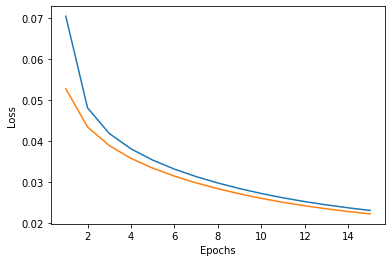

In [ ]:
# Implement

# Define the mini-batch size
batch_size = 1000

# Define how many epochs we want the training to be
epochs = 15

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

mnist_validation = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=False)



network = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

# Initialize the optimizer
# In addition to changing optimizer you can try to change other parameters like learning rate (lr)
optimizer = optim.SGD(network.parameters(), lr=0.25)

# Initialize the loss function
loss_function = nn.MSELoss()

### EDIT CODE ABOVE TO CHANGE THE NETWORK AND ITS OPTIMIZING PROCEDURE ###

# An Embedding layer used for turning int into one-hot (0 -> [1,0,0,0,0,0,0,0,0,0], 5 -> [0,0,0,0,0,1,0,0,0,0])
to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)
best_network = network
best_validation = 10000
# Extract some images from the dataset and have the new predict what digit they are
def predict_on_images(iterator, images_to_show):
    for index in range(images_to_show):
        # Get the next batch of images
        images, labels = next(iterator)

        plot_digit(images[0])

        # Transform the images into a single list of pixels since our network takes that as its input
        input_tensor = images[0].view(1,784)
        # Run the input through our network to get a prediction
        prediction = network(input_tensor)
        # Extract which prediction had the highest probability
        guess = torch.argmax(prediction[0], dim=-1)
        # Show the predicted digit and the actual digit
        print(f'Prediction: {guess.item()} - Actual: {labels[0].item()}')

def test(validate_loader):
    correct_guesses = 0
    image_amount = 0
    for batch_nr, (images, labels) in enumerate(validate_loader):
        # Reshape the images to a single vector (28*28 = 784)
        images = images.view(-1,784)
        # Run the input through our network to get a prediction
        prediction = best_network(images)
        # Extract which prediction had the highest probability
        i = 0
        for guesses in prediction:
            guess = torch.argmax(guesses, dim=-1)
            if guess == labels[i].item():
                correct_guesses+=1
            print(f'Prediction: {guess} - Actual: {labels[i]}image:{i}')
            i+=1
            image_amount +=1
        # Show the predicted digit and the actual digit
        print(f'Prediction: {guess.item()} - Actual: {labels[0].item()}')
    result = correct_guesses/image_amount
    print(f'Percentage correct: {result} Tested images: {image_amount} Correct guesses: {correct_guesses}')

# Have the untrained network predict on some images
print('Predicting with the randomly initialized network before training to see what happens')
predict_on_images(iterator = iter(train_loader), images_to_show = 3)
test(validation_loader)
#print(f'Epoch {epoch+1} - Loss: {loss}') #print epoch loss
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = 0
    cycle_amount = 0
    print('\n')
    # For each batch of data (since the dataset is too large to run all data through the network at once)
    for batch_nr, (images, labels) in enumerate(train_loader):

        # Extract the labels and turn them into one-hot representation (note: not all loss functions needs this)
        labels = to_onehot(labels)

        # Reshape the images to a single vector (28*28 = 784)
        images = images.view(-1,784)

        # Predict for each digit in the batch whatclass they belong to
        prediction = network(images) # WRITE THE CODE TO RUN THE IMAGES THROUGH THE NETWORK
        flag = True
        if flag:
            #print(prediction)
            flag = False
        # Calculate the loss of the prediction by comparing to the expected output
        loss = loss_function(prediction, labels) # WRITE THE CODE TO CALCULATE THE LOSS BY COMPARING THE PREDICTION TO THE ACTUAL LABELS
        train_loss += loss
        cycle_amount += 1
        # Backpropagate the loss through the network to find the gradients of all parameters
        loss.backward() # WRITE CODE TO BACKPROPOGATE THE LOSS

        # Update the parameters along their gradients
        optimizer.step() # WRITE THE CODE TO OPTIMIZE PARAMETERS BY STEPPING ALONG THE GRADIENTS

        # Clear stored gradient values
        optimizer.zero_grad() # WRITE THE CODE TO REMOVE THE USED GRADIENTS BEFORE THE NEXT ITERATION OF THE LOOP

        #Print the epoch, batch, and loss
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                epoch+1, batch_nr+1, len(train_loader), loss
            ),
            end=''
        )
    print('\n')
    val = 0
    train_loss = train_loss/cycle_amount
    loss_total = 0
    print(f"Training loss: {train_loss}")
    train_losses.append(train_loss)
    for batch_nr, (images, labels) in enumerate(validation_loader):
        val+=1
        # Extract the labels and turn them into one-hot representation (note: not all loss functions needs this)
        labels = to_onehot(labels)

        # Reshape the images to a single vector (28*28 = 784)
        images = images.view(-1,784)

        # Predict for each digit in the batch whatclass they belong to
        prediction = network(images) # WRITE THE CODE TO RUN THE IMAGES THROUGH THE NETWORK

        # Calculate the loss of the prediction by comparing to the expected output
        loss = loss_function(prediction, labels) # WRITE THE CODE TO CALCULATE THE LOSS BY COMPARING THE PREDICTION TO THE ACTUAL LABELS
        loss_total += loss
        #Print the epoch, batch, and loss
        print(
            '\rValidation: Epoch {} [{}/{}] - Loss: {}'.format(
                epoch+1, batch_nr+1, len(validation_loader), loss
            ),
            end=''
        )
        #print(f"       Tested batches : {val}")
    loss_total = loss_total/10
    val_losses.append(loss_total)
    print(f"Loss average for epoch validation: {loss_total}")
    if loss_total<best_validation:
        best_network = network
        best_validation = loss_total
    network = best_network


print('Predicting post training')
#predict_on_images(iterator = iter(validation_loader), images_to_show = 20)
with torch.no_grad():
    test(test_loader)
    plt.plot(range(1,epochs+1),train_losses)
    plt.plot(range(1,epochs+1),val_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Part 3

## Implement a classifier using numpy
Implement a similar 2 layer neural network, without using a high-level machine learning library like pytorch. It should function the same as the network in Part 2. The code block below contains code to change the training data from the DataLoader format to the "raw" numpy format. It also contains some comments to guide you in the right direction. **Please note that this solution should not "scale" hence it is 100% OK to just have two weight matrices variables.**

### The foward pass
This is easy. Recall that each differnt layer is calculated by the formula:
$$ y = g(\mathbf{W}*\mathbf{x} + b) $$
where $W$ is the weight matrix, $x$ the input, $b$ the bias and $g$ the non-linearity. For this exercise you are allowed to put $b = 0$ for simplicity when calculating the backwards pass.

### Backward pass
This can be tricky. In canvas there is lecture material which explains back propogation and all the maths behind it. It should be under *Modules > Artificial Neural Networks (ANN) - Part 1 > Lecture: Backpropagation derivation.mp4*. This, the supplementary material for the lecture, together with the course book should be enough material for you to be able to implement the training algorithm.

### Weight update
Once you have calculated the gradient of both weight matrixes, this is updated by:
$$ W_i = W_i - \gamma \dfrac{dL}{dW_i} $$
where $\gamma$ is the step size, or learning rate.

**Exercise:** Implement a 2-layer NN and training, valdiation, and testing like in Part 2, but this time implementing everything using Numpy, which requires you to define your own forward pass, backward pass, and parameter updates. Then plot the training and validation scores and print the test accuracy which should be at least 40%.

***Remember*** to run all your code before grading so the TA doesn't have to wait around for long training runs.

Test loss: 2.757223751945459
Validation loss: 0.17818575446600834
Test loss: 0.12778325292053003
Validation loss: 0.08081441296876399
Test loss: 0.07144544382727631
Validation loss: 0.0535877244975018
Test loss: 0.05099586142950722
Validation loss: 0.04129267628537237
Test loss: 0.04057081737832384
Validation loss: 0.03442643192639565
Test loss: 0.03433042899134849
Validation loss: 0.03009358013306738
Test loss: 0.030197294178328775
Validation loss: 0.027105095749967095
Test loss: 0.027267660923602555
Validation loss: 0.024931558001970344
Test loss: 0.025091755579263277
Validation loss: 0.023292518516285377
Test loss: 0.02341697591284197
Validation loss: 0.02201696907148046


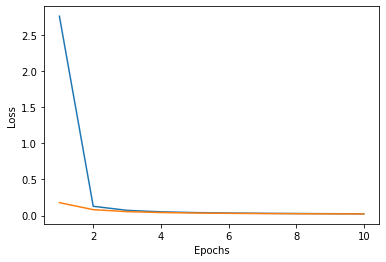

Prediction: [7] - Actual: 7image:0
Prediction: [6] - Actual: 2image:1
Prediction: [1] - Actual: 1image:2
Prediction: [0] - Actual: 0image:3
Prediction: [9] - Actual: 4image:4
Prediction: [1] - Actual: 1image:5
Prediction: [4] - Actual: 4image:6
Prediction: [5] - Actual: 9image:7
Prediction: [1] - Actual: 5image:8
Prediction: [9] - Actual: 9image:9
Prediction: [0] - Actual: 0image:10
Prediction: [6] - Actual: 6image:11
Prediction: [7] - Actual: 9image:12
Prediction: [0] - Actual: 0image:13
Prediction: [1] - Actual: 1image:14
Prediction: [4] - Actual: 5image:15
Prediction: [9] - Actual: 9image:16
Prediction: [7] - Actual: 7image:17
Prediction: [5] - Actual: 3image:18
Prediction: [9] - Actual: 4image:19
Prediction: [7] - Actual: 9image:20
Prediction: [6] - Actual: 6image:21
Prediction: [6] - Actual: 6image:22
Prediction: [6] - Actual: 5image:23
Prediction: [9] - Actual: 4image:24
Prediction: [0] - Actual: 0image:25
Prediction: [7] - Actual: 7image:26
Prediction: [4] - Actual: 4image:27
Pr

Prediction: [1] - Actual: 1image:393
Prediction: [7] - Actual: 9image:394
Prediction: [3] - Actual: 5image:395
Prediction: [2] - Actual: 2image:396
Prediction: [5] - Actual: 5image:397
Prediction: [4] - Actual: 4image:398
Prediction: [9] - Actual: 4image:399
Prediction: [2] - Actual: 2image:400
Prediction: [3] - Actual: 8image:401
Prediction: [6] - Actual: 3image:402
Prediction: [9] - Actual: 8image:403
Prediction: [6] - Actual: 2image:404
Prediction: [9] - Actual: 4image:405
Prediction: [6] - Actual: 5image:406
Prediction: [0] - Actual: 0image:407
Prediction: [3] - Actual: 3image:408
Prediction: [1] - Actual: 1image:409
Prediction: [7] - Actual: 7image:410
Prediction: [7] - Actual: 7image:411
Prediction: [9] - Actual: 5image:412
Prediction: [7] - Actual: 7image:413
Prediction: [1] - Actual: 9image:414
Prediction: [7] - Actual: 7image:415
Prediction: [1] - Actual: 1image:416
Prediction: [7] - Actual: 9image:417
Prediction: [8] - Actual: 2image:418
Prediction: [1] - Actual: 1image:419
P

Prediction: [1] - Actual: 0image:763
Prediction: [4] - Actual: 2image:764
Prediction: [7] - Actual: 4image:765
Prediction: [3] - Actual: 5image:766
Prediction: [1] - Actual: 1image:767
Prediction: [1] - Actual: 1image:768
Prediction: [6] - Actual: 6image:769
Prediction: [4] - Actual: 4image:770
Prediction: [7] - Actual: 7image:771
Prediction: [1] - Actual: 1image:772
Prediction: [7] - Actual: 9image:773
Prediction: [9] - Actual: 4image:774
Prediction: [6] - Actual: 2image:775
Prediction: [3] - Actual: 4image:776
Prediction: [1] - Actual: 1image:777
Prediction: [3] - Actual: 5image:778
Prediction: [4] - Actual: 5image:779
Prediction: [6] - Actual: 3image:780
Prediction: [9] - Actual: 8image:781
Prediction: [4] - Actual: 3image:782
Prediction: [1] - Actual: 1image:783
Prediction: [3] - Actual: 4image:784
Prediction: [3] - Actual: 5image:785
Prediction: [6] - Actual: 6image:786
Prediction: [4] - Actual: 8image:787
Prediction: [9] - Actual: 9image:788
Prediction: [9] - Actual: 4image:789
P

Prediction: [9] - Actual: 9image:0
Prediction: [0] - Actual: 0image:1
Prediction: [0] - Actual: 2image:2
Prediction: [3] - Actual: 5image:3
Prediction: [1] - Actual: 1image:4
Prediction: [9] - Actual: 9image:5
Prediction: [7] - Actual: 7image:6
Prediction: [7] - Actual: 8image:7
Prediction: [1] - Actual: 1image:8
Prediction: [0] - Actual: 0image:9
Prediction: [8] - Actual: 4image:10
Prediction: [1] - Actual: 1image:11
Prediction: [7] - Actual: 7image:12
Prediction: [9] - Actual: 9image:13
Prediction: [8] - Actual: 6image:14
Prediction: [7] - Actual: 4image:15
Prediction: [3] - Actual: 2image:16
Prediction: [6] - Actual: 6image:17
Prediction: [3] - Actual: 8image:18
Prediction: [1] - Actual: 1image:19
Prediction: [3] - Actual: 3image:20
Prediction: [7] - Actual: 7image:21
Prediction: [9] - Actual: 5image:22
Prediction: [4] - Actual: 4image:23
Prediction: [7] - Actual: 4image:24
Prediction: [1] - Actual: 1image:25
Prediction: [3] - Actual: 8image:26
Prediction: [1] - Actual: 1image:27
Pr

Prediction: [3] - Actual: 3image:278
Prediction: [8] - Actual: 4image:279
Prediction: [1] - Actual: 1image:280
Prediction: [3] - Actual: 5image:281
Prediction: [9] - Actual: 9image:282
Prediction: [9] - Actual: 7image:283
Prediction: [4] - Actual: 3image:284
Prediction: [1] - Actual: 5image:285
Prediction: [3] - Actual: 8image:286
Prediction: [6] - Actual: 8image:287
Prediction: [9] - Actual: 0image:288
Prediction: [6] - Actual: 5image:289
Prediction: [6] - Actual: 3image:290
Prediction: [0] - Actual: 3image:291
Prediction: [6] - Actual: 6image:292
Prediction: [6] - Actual: 6image:293
Prediction: [6] - Actual: 0image:294
Prediction: [1] - Actual: 1image:295
Prediction: [6] - Actual: 6image:296
Prediction: [0] - Actual: 0image:297
Prediction: [4] - Actual: 3image:298
Prediction: [7] - Actual: 5image:299
Prediction: [4] - Actual: 4image:300
Prediction: [9] - Actual: 4image:301
Prediction: [1] - Actual: 1image:302
Prediction: [3] - Actual: 2image:303
Prediction: [9] - Actual: 9image:304
P

Prediction: [6] - Actual: 5image:677
Prediction: [3] - Actual: 2image:678
Prediction: [3] - Actual: 4image:679
Prediction: [3] - Actual: 4image:680
Prediction: [7] - Actual: 3image:681
Prediction: [6] - Actual: 2image:682
Prediction: [3] - Actual: 3image:683
Prediction: [1] - Actual: 5image:684
Prediction: [6] - Actual: 6image:685
Prediction: [9] - Actual: 8image:686
Prediction: [9] - Actual: 8image:687
Prediction: [1] - Actual: 6image:688
Prediction: [0] - Actual: 2image:689
Prediction: [3] - Actual: 3image:690
Prediction: [1] - Actual: 1image:691
Prediction: [0] - Actual: 0image:692
Prediction: [3] - Actual: 5image:693
Prediction: [6] - Actual: 8image:694
Prediction: [7] - Actual: 9image:695
Prediction: [3] - Actual: 2image:696
Prediction: [9] - Actual: 9image:697
Prediction: [6] - Actual: 6image:698
Prediction: [7] - Actual: 7image:699
Prediction: [0] - Actual: 0image:700
Prediction: [5] - Actual: 4image:701
Prediction: [1] - Actual: 8image:702
Prediction: [0] - Actual: 7image:703
P

Prediction: [6] - Actual: 6image:0
Prediction: [3] - Actual: 5image:1
Prediction: [6] - Actual: 6image:2
Prediction: [3] - Actual: 5image:3
Prediction: [1] - Actual: 8image:4
Prediction: [2] - Actual: 4image:5
Prediction: [6] - Actual: 6image:6
Prediction: [3] - Actual: 4image:7
Prediction: [3] - Actual: 3image:8
Prediction: [9] - Actual: 9image:9
Prediction: [8] - Actual: 1image:10
Prediction: [2] - Actual: 3image:11
Prediction: [9] - Actual: 4image:12
Prediction: [1] - Actual: 1image:13
Prediction: [7] - Actual: 9image:14
Prediction: [1] - Actual: 1image:15
Prediction: [8] - Actual: 7image:16
Prediction: [1] - Actual: 1image:17
Prediction: [1] - Actual: 1image:18
Prediction: [9] - Actual: 9image:19
Prediction: [3] - Actual: 3image:20
Prediction: [7] - Actual: 5image:21
Prediction: [6] - Actual: 4image:22
Prediction: [6] - Actual: 0image:23
Prediction: [2] - Actual: 7image:24
Prediction: [6] - Actual: 3image:25
Prediction: [6] - Actual: 6image:26
Prediction: [1] - Actual: 1image:27
Pr

Prediction: [9] - Actual: 4image:394
Prediction: [9] - Actual: 8image:395
Prediction: [6] - Actual: 2image:396
Prediction: [9] - Actual: 2image:397
Prediction: [1] - Actual: 1image:398
Prediction: [7] - Actual: 7image:399
Prediction: [8] - Actual: 5image:400
Prediction: [4] - Actual: 4image:401
Prediction: [9] - Actual: 4image:402
Prediction: [0] - Actual: 0image:403
Prediction: [8] - Actual: 4image:404
Prediction: [3] - Actual: 3image:405
Prediction: [9] - Actual: 9image:406
Prediction: [7] - Actual: 7image:407
Prediction: [1] - Actual: 3image:408
Prediction: [1] - Actual: 1image:409
Prediction: [6] - Actual: 0image:410
Prediction: [1] - Actual: 1image:411
Prediction: [1] - Actual: 2image:412
Prediction: [0] - Actual: 5image:413
Prediction: [3] - Actual: 9image:414
Prediction: [6] - Actual: 2image:415
Prediction: [1] - Actual: 1image:416
Prediction: [6] - Actual: 0image:417
Prediction: [1] - Actual: 1image:418
Prediction: [3] - Actual: 8image:419
Prediction: [8] - Actual: 9image:420
P

Prediction: [8] - Actual: 5image:948
Prediction: [8] - Actual: 8image:949
Prediction: [1] - Actual: 1image:950
Prediction: [6] - Actual: 5image:951
Prediction: [3] - Actual: 3image:952
Prediction: [3] - Actual: 3image:953
Prediction: [6] - Actual: 0image:954
Prediction: [3] - Actual: 3image:955
Prediction: [3] - Actual: 5image:956
Prediction: [2] - Actual: 5image:957
Prediction: [9] - Actual: 9image:958
Prediction: [2] - Actual: 2image:959
Prediction: [3] - Actual: 8image:960
Prediction: [7] - Actual: 7image:961
Prediction: [6] - Actual: 0image:962
Prediction: [0] - Actual: 4image:963
Prediction: [9] - Actual: 9image:964
Prediction: [1] - Actual: 1image:965
Prediction: [9] - Actual: 9image:966
Prediction: [7] - Actual: 7image:967
Prediction: [1] - Actual: 7image:968
Prediction: [0] - Actual: 5image:969
Prediction: [9] - Actual: 5image:970
Prediction: [6] - Actual: 2image:971
Prediction: [0] - Actual: 0image:972
Prediction: [9] - Actual: 9image:973
Prediction: [1] - Actual: 1image:974
P

Prediction: [6] - Actual: 7image:316
Prediction: [0] - Actual: 0image:317
Prediction: [6] - Actual: 2image:318
Prediction: [3] - Actual: 8image:319
Prediction: [1] - Actual: 1image:320
Prediction: [8] - Actual: 5image:321
Prediction: [0] - Actual: 0image:322
Prediction: [8] - Actual: 8image:323
Prediction: [3] - Actual: 8image:324
Prediction: [6] - Actual: 0image:325
Prediction: [1] - Actual: 3image:326
Prediction: [3] - Actual: 2image:327
Prediction: [7] - Actual: 7image:328
Prediction: [3] - Actual: 7image:329
Prediction: [4] - Actual: 2image:330
Prediction: [6] - Actual: 6image:331
Prediction: [4] - Actual: 4image:332
Prediction: [7] - Actual: 7image:333
Prediction: [1] - Actual: 5image:334
Prediction: [2] - Actual: 5image:335
Prediction: [3] - Actual: 5image:336
Prediction: [6] - Actual: 2image:337
Prediction: [4] - Actual: 9image:338
Prediction: [8] - Actual: 2image:339
Prediction: [6] - Actual: 8image:340
Prediction: [2] - Actual: 4image:341
Prediction: [3] - Actual: 6image:342
P

Prediction: [6] - Actual: 1image:641
Prediction: [3] - Actual: 3image:642
Prediction: [7] - Actual: 7image:643
Prediction: [8] - Actual: 8image:644
Prediction: [9] - Actual: 5image:645
Prediction: [6] - Actual: 0image:646
Prediction: [7] - Actual: 7image:647
Prediction: [1] - Actual: 1image:648
Prediction: [1] - Actual: 1image:649
Prediction: [0] - Actual: 0image:650
Prediction: [1] - Actual: 1image:651
Prediction: [1] - Actual: 1image:652
Prediction: [8] - Actual: 4image:653
Prediction: [1] - Actual: 5image:654
Prediction: [0] - Actual: 2image:655
Prediction: [9] - Actual: 7image:656
Prediction: [6] - Actual: 6image:657
Prediction: [1] - Actual: 2image:658
Prediction: [3] - Actual: 3image:659
Prediction: [0] - Actual: 0image:660
Prediction: [2] - Actual: 2image:661
Prediction: [3] - Actual: 8image:662
Prediction: [7] - Actual: 5image:663
Prediction: [8] - Actual: 9image:664
Prediction: [6] - Actual: 6image:665
Prediction: [7] - Actual: 9image:666
Prediction: [7] - Actual: 7image:667
P

Prediction: [2] - Actual: 2image:913
Prediction: [6] - Actual: 6image:914
Prediction: [9] - Actual: 4image:915
Prediction: [3] - Actual: 3image:916
Prediction: [9] - Actual: 5image:917
Prediction: [1] - Actual: 5image:918
Prediction: [1] - Actual: 1image:919
Prediction: [7] - Actual: 7image:920
Prediction: [3] - Actual: 2image:921
Prediction: [1] - Actual: 1image:922
Prediction: [6] - Actual: 6image:923
Prediction: [9] - Actual: 9image:924
Prediction: [2] - Actual: 1image:925
Prediction: [3] - Actual: 9image:926
Prediction: [9] - Actual: 9image:927
Prediction: [6] - Actual: 5image:928
Prediction: [4] - Actual: 5image:929
Prediction: [1] - Actual: 1image:930
Prediction: [6] - Actual: 6image:931
Prediction: [2] - Actual: 2image:932
Prediction: [2] - Actual: 2image:933
Prediction: [3] - Actual: 8image:934
Prediction: [0] - Actual: 6image:935
Prediction: [7] - Actual: 7image:936
Prediction: [1] - Actual: 1image:937
Prediction: [7] - Actual: 4image:938
Prediction: [6] - Actual: 6image:939
P

Prediction: [2] - Actual: 2image:275
Prediction: [3] - Actual: 3image:276
Prediction: [6] - Actual: 3image:277
Prediction: [0] - Actual: 0image:278
Prediction: [4] - Actual: 2image:279
Prediction: [9] - Actual: 9image:280
Prediction: [6] - Actual: 0image:281
Prediction: [0] - Actual: 0image:282
Prediction: [8] - Actual: 9image:283
Prediction: [6] - Actual: 9image:284
Prediction: [6] - Actual: 6image:285
Prediction: [0] - Actual: 0image:286
Prediction: [3] - Actual: 9image:287
Prediction: [9] - Actual: 3image:288
Prediction: [0] - Actual: 2image:289
Prediction: [3] - Actual: 8image:290
Prediction: [9] - Actual: 4image:291
Prediction: [1] - Actual: 1image:292
Prediction: [3] - Actual: 9image:293
Prediction: [1] - Actual: 9image:294
Prediction: [7] - Actual: 7image:295
Prediction: [8] - Actual: 2image:296
Prediction: [1] - Actual: 7image:297
Prediction: [3] - Actual: 9image:298
Prediction: [7] - Actual: 9image:299
Prediction: [6] - Actual: 5image:300
Prediction: [8] - Actual: 9image:301
P

Prediction: [1] - Actual: 1image:564
Prediction: [6] - Actual: 6image:565
Prediction: [7] - Actual: 7image:566
Prediction: [3] - Actual: 4image:567
Prediction: [9] - Actual: 7image:568
Prediction: [3] - Actual: 5image:569
Prediction: [4] - Actual: 9image:570
Prediction: [0] - Actual: 6image:571
Prediction: [8] - Actual: 8image:572
Prediction: [2] - Actual: 2image:573
Prediction: [1] - Actual: 1image:574
Prediction: [0] - Actual: 4image:575
Prediction: [3] - Actual: 4image:576
Prediction: [8] - Actual: 5image:577
Prediction: [7] - Actual: 7image:578
Prediction: [3] - Actual: 6image:579
Prediction: [1] - Actual: 1image:580
Prediction: [3] - Actual: 3image:581
Prediction: [1] - Actual: 2image:582
Prediction: [3] - Actual: 5image:583
Prediction: [8] - Actual: 9image:584
Prediction: [3] - Actual: 9image:585
Prediction: [8] - Actual: 3image:586
Prediction: [6] - Actual: 6image:587
Prediction: [1] - Actual: 1image:588
Prediction: [0] - Actual: 1image:589
Prediction: [9] - Actual: 4image:590
P

Prediction: [1] - Actual: 9image:840
Prediction: [1] - Actual: 3image:841
Prediction: [3] - Actual: 4image:842
Prediction: [7] - Actual: 9image:843
Prediction: [0] - Actual: 5image:844
Prediction: [3] - Actual: 8image:845
Prediction: [3] - Actual: 9image:846
Prediction: [1] - Actual: 1image:847
Prediction: [2] - Actual: 2image:848
Prediction: [3] - Actual: 8image:849
Prediction: [6] - Actual: 8image:850
Prediction: [6] - Actual: 6image:851
Prediction: [3] - Actual: 8image:852
Prediction: [1] - Actual: 1image:853
Prediction: [0] - Actual: 3image:854
Prediction: [7] - Actual: 7image:855
Prediction: [7] - Actual: 9image:856
Prediction: [3] - Actual: 0image:857
Prediction: [1] - Actual: 1image:858
Prediction: [1] - Actual: 1image:859
Prediction: [9] - Actual: 4image:860
Prediction: [9] - Actual: 7image:861
Prediction: [5] - Actual: 0image:862
Prediction: [7] - Actual: 8image:863
Prediction: [1] - Actual: 1image:864
Prediction: [7] - Actual: 7image:865
Prediction: [3] - Actual: 4image:866
P

Prediction: [7] - Actual: 7image:310
Prediction: [3] - Actual: 9image:311
Prediction: [8] - Actual: 4image:312
Prediction: [7] - Actual: 7image:313
Prediction: [1] - Actual: 1image:314
Prediction: [9] - Actual: 9image:315
Prediction: [1] - Actual: 1image:316
Prediction: [7] - Actual: 7image:317
Prediction: [1] - Actual: 1image:318
Prediction: [9] - Actual: 4image:319
Prediction: [0] - Actual: 0image:320
Prediction: [0] - Actual: 0image:321
Prediction: [7] - Actual: 4image:322
Prediction: [1] - Actual: 1image:323
Prediction: [7] - Actual: 7image:324
Prediction: [3] - Actual: 5image:325
Prediction: [7] - Actual: 7image:326
Prediction: [1] - Actual: 1image:327
Prediction: [3] - Actual: 3image:328
Prediction: [0] - Actual: 3image:329
Prediction: [3] - Actual: 3image:330
Prediction: [6] - Actual: 1image:331
Prediction: [6] - Actual: 6image:332
Prediction: [9] - Actual: 9image:333
Prediction: [7] - Actual: 7image:334
Prediction: [7] - Actual: 4image:335
Prediction: [7] - Actual: 3image:336
P

Prediction: [6] - Actual: 6image:660
Prediction: [1] - Actual: 1image:661
Prediction: [0] - Actual: 5image:662
Prediction: [7] - Actual: 7image:663
Prediction: [1] - Actual: 4image:664
Prediction: [6] - Actual: 6image:665
Prediction: [1] - Actual: 1image:666
Prediction: [0] - Actual: 2image:667
Prediction: [9] - Actual: 5image:668
Prediction: [0] - Actual: 0image:669
Prediction: [7] - Actual: 7image:670
Prediction: [7] - Actual: 9image:671
Prediction: [9] - Actual: 9image:672
Prediction: [0] - Actual: 0image:673
Prediction: [6] - Actual: 3image:674
Prediction: [3] - Actual: 8image:675
Prediction: [3] - Actual: 4image:676
Prediction: [6] - Actual: 4image:677
Prediction: [7] - Actual: 8image:678
Prediction: [1] - Actual: 1image:679
Prediction: [1] - Actual: 8image:680
Prediction: [6] - Actual: 6image:681
Prediction: [3] - Actual: 5image:682
Prediction: [3] - Actual: 9image:683
Prediction: [0] - Actual: 0image:684
Prediction: [0] - Actual: 0image:685
Prediction: [0] - Actual: 0image:686
P

Prediction: [7] - Actual: 9image:0
Prediction: [3] - Actual: 8image:1
Prediction: [6] - Actual: 6image:2
Prediction: [0] - Actual: 0image:3
Prediction: [3] - Actual: 8image:4
Prediction: [1] - Actual: 1image:5
Prediction: [1] - Actual: 7image:6
Prediction: [7] - Actual: 7image:7
Prediction: [1] - Actual: 1image:8
Prediction: [3] - Actual: 3image:9
Prediction: [5] - Actual: 2image:10
Prediction: [3] - Actual: 3image:11
Prediction: [1] - Actual: 1image:12
Prediction: [9] - Actual: 4image:13
Prediction: [8] - Actual: 2image:14
Prediction: [0] - Actual: 0image:15
Prediction: [0] - Actual: 0image:16
Prediction: [7] - Actual: 7image:17
Prediction: [3] - Actual: 8image:18
Prediction: [7] - Actual: 4image:19
Prediction: [6] - Actual: 6image:20
Prediction: [1] - Actual: 4image:21
Prediction: [7] - Actual: 9image:22
Prediction: [3] - Actual: 3image:23
Prediction: [3] - Actual: 8image:24
Prediction: [9] - Actual: 4image:25
Prediction: [7] - Actual: 7image:26
Prediction: [6] - Actual: 2image:27
Pr

Prediction: [7] - Actual: 7image:366
Prediction: [9] - Actual: 4image:367
Prediction: [2] - Actual: 5image:368
Prediction: [4] - Actual: 4image:369
Prediction: [3] - Actual: 3image:370
Prediction: [3] - Actual: 3image:371
Prediction: [3] - Actual: 8image:372
Prediction: [6] - Actual: 4image:373
Prediction: [1] - Actual: 1image:374
Prediction: [1] - Actual: 1image:375
Prediction: [7] - Actual: 9image:376
Prediction: [7] - Actual: 7image:377
Prediction: [9] - Actual: 4image:378
Prediction: [3] - Actual: 3image:379
Prediction: [7] - Actual: 7image:380
Prediction: [6] - Actual: 3image:381
Prediction: [3] - Actual: 3image:382
Prediction: [6] - Actual: 0image:383
Prediction: [6] - Actual: 2image:384
Prediction: [6] - Actual: 5image:385
Prediction: [5] - Actual: 5image:386
Prediction: [6] - Actual: 6image:387
Prediction: [6] - Actual: 6image:388
Prediction: [3] - Actual: 3image:389
Prediction: [7] - Actual: 5image:390
Prediction: [6] - Actual: 2image:391
Prediction: [7] - Actual: 5image:392
P

Prediction: [6] - Actual: 2image:744
Prediction: [3] - Actual: 3image:745
Prediction: [3] - Actual: 5image:746
Prediction: [9] - Actual: 9image:747
Prediction: [1] - Actual: 1image:748
Prediction: [6] - Actual: 6image:749
Prediction: [0] - Actual: 0image:750
Prediction: [1] - Actual: 1image:751
Prediction: [0] - Actual: 0image:752
Prediction: [6] - Actual: 0image:753
Prediction: [3] - Actual: 2image:754
Prediction: [8] - Actual: 8image:755
Prediction: [0] - Actual: 7image:756
Prediction: [1] - Actual: 1image:757
Prediction: [8] - Actual: 1image:758
Prediction: [6] - Actual: 4image:759
Prediction: [0] - Actual: 0image:760
Prediction: [6] - Actual: 4image:761
Prediction: [0] - Actual: 7image:762
Prediction: [3] - Actual: 3image:763
Prediction: [3] - Actual: 6image:764
Prediction: [1] - Actual: 8image:765
Prediction: [0] - Actual: 0image:766
Prediction: [3] - Actual: 3image:767
Prediction: [2] - Actual: 7image:768
Prediction: [0] - Actual: 4image:769
Prediction: [0] - Actual: 0image:770
P

Prediction: [1] - Actual: 1image:0
Prediction: [9] - Actual: 2image:1
Prediction: [8] - Actual: 2image:2
Prediction: [6] - Actual: 5image:3
Prediction: [3] - Actual: 8image:4
Prediction: [1] - Actual: 1image:5
Prediction: [3] - Actual: 3image:6
Prediction: [2] - Actual: 2image:7
Prediction: [9] - Actual: 9image:8
Prediction: [7] - Actual: 4image:9
Prediction: [3] - Actual: 3image:10
Prediction: [8] - Actual: 8image:11
Prediction: [2] - Actual: 2image:12
Prediction: [2] - Actual: 2image:13
Prediction: [1] - Actual: 1image:14
Prediction: [2] - Actual: 2image:15
Prediction: [3] - Actual: 8image:16
Prediction: [6] - Actual: 6image:17
Prediction: [3] - Actual: 5image:18
Prediction: [1] - Actual: 1image:19
Prediction: [6] - Actual: 6image:20
Prediction: [7] - Actual: 7image:21
Prediction: [2] - Actual: 2image:22
Prediction: [3] - Actual: 1image:23
Prediction: [3] - Actual: 3image:24
Prediction: [7] - Actual: 9image:25
Prediction: [3] - Actual: 3image:26
Prediction: [8] - Actual: 8image:27
Pr

Prediction: [1] - Actual: 1image:340
Prediction: [9] - Actual: 4image:341
Prediction: [6] - Actual: 0image:342
Prediction: [6] - Actual: 6image:343
Prediction: [1] - Actual: 1image:344
Prediction: [0] - Actual: 2image:345
Prediction: [6] - Actual: 6image:346
Prediction: [9] - Actual: 9image:347
Prediction: [0] - Actual: 2image:348
Prediction: [3] - Actual: 2image:349
Prediction: [3] - Actual: 3image:350
Prediction: [6] - Actual: 5image:351
Prediction: [3] - Actual: 5image:352
Prediction: [1] - Actual: 1image:353
Prediction: [6] - Actual: 0image:354
Prediction: [7] - Actual: 7image:355
Prediction: [9] - Actual: 7image:356
Prediction: [9] - Actual: 9image:357
Prediction: [6] - Actual: 6image:358
Prediction: [2] - Actual: 2image:359
Prediction: [9] - Actual: 9image:360
Prediction: [3] - Actual: 4image:361
Prediction: [7] - Actual: 7image:362
Prediction: [3] - Actual: 0image:363
Prediction: [2] - Actual: 2image:364
Prediction: [3] - Actual: 3image:365
Prediction: [3] - Actual: 4image:366
P

Prediction: [2] - Actual: 2image:716
Prediction: [1] - Actual: 1image:717
Prediction: [8] - Actual: 8image:718
Prediction: [3] - Actual: 3image:719
Prediction: [3] - Actual: 8image:720
Prediction: [6] - Actual: 6image:721
Prediction: [1] - Actual: 1image:722
Prediction: [0] - Actual: 0image:723
Prediction: [6] - Actual: 2image:724
Prediction: [1] - Actual: 1image:725
Prediction: [9] - Actual: 4image:726
Prediction: [6] - Actual: 0image:727
Prediction: [1] - Actual: 1image:728
Prediction: [2] - Actual: 2image:729
Prediction: [3] - Actual: 3image:730
Prediction: [9] - Actual: 4image:731
Prediction: [3] - Actual: 5image:732
Prediction: [6] - Actual: 6image:733
Prediction: [7] - Actual: 7image:734
Prediction: [3] - Actual: 8image:735
Prediction: [1] - Actual: 9image:736
Prediction: [0] - Actual: 0image:737
Prediction: [1] - Actual: 1image:738
Prediction: [2] - Actual: 2image:739
Prediction: [3] - Actual: 3image:740
Prediction: [0] - Actual: 4image:741
Prediction: [6] - Actual: 5image:742
P

Prediction: [8] - Actual: 4image:0
Prediction: [9] - Actual: 9image:1
Prediction: [7] - Actual: 9image:2
Prediction: [1] - Actual: 7image:3
Prediction: [8] - Actual: 1image:4
Prediction: [1] - Actual: 1image:5
Prediction: [9] - Actual: 9image:6
Prediction: [0] - Actual: 0image:7
Prediction: [8] - Actual: 7image:8
Prediction: [8] - Actual: 8image:9
Prediction: [3] - Actual: 3image:10
Prediction: [3] - Actual: 4image:11
Prediction: [8] - Actual: 8image:12
Prediction: [6] - Actual: 6image:13
Prediction: [3] - Actual: 3image:14
Prediction: [0] - Actual: 8image:15
Prediction: [0] - Actual: 0image:16
Prediction: [9] - Actual: 9image:17
Prediction: [2] - Actual: 6image:18
Prediction: [3] - Actual: 2image:19
Prediction: [1] - Actual: 1image:20
Prediction: [0] - Actual: 0image:21
Prediction: [1] - Actual: 1image:22
Prediction: [0] - Actual: 0image:23
Prediction: [6] - Actual: 6image:24
Prediction: [2] - Actual: 2image:25
Prediction: [3] - Actual: 3image:26
Prediction: [8] - Actual: 8image:27
Pr

Prediction: [1] - Actual: 1image:360
Prediction: [7] - Actual: 2image:361
Prediction: [0] - Actual: 3image:362
Prediction: [4] - Actual: 4image:363
Prediction: [7] - Actual: 7image:364
Prediction: [2] - Actual: 2image:365
Prediction: [3] - Actual: 5image:366
Prediction: [1] - Actual: 1image:367
Prediction: [6] - Actual: 6image:368
Prediction: [9] - Actual: 4image:369
Prediction: [3] - Actual: 3image:370
Prediction: [9] - Actual: 9image:371
Prediction: [7] - Actual: 9image:372
Prediction: [0] - Actual: 0image:373
Prediction: [9] - Actual: 9image:374
Prediction: [7] - Actual: 7image:375
Prediction: [1] - Actual: 1image:376
Prediction: [6] - Actual: 6image:377
Prediction: [9] - Actual: 4image:378
Prediction: [3] - Actual: 3image:379
Prediction: [6] - Actual: 6image:380
Prediction: [8] - Actual: 2image:381
Prediction: [1] - Actual: 0image:382
Prediction: [9] - Actual: 9image:383
Prediction: [8] - Actual: 8image:384
Prediction: [6] - Actual: 6image:385
Prediction: [3] - Actual: 5image:386
P

Prediction: [9] - Actual: 8image:722
Prediction: [7] - Actual: 9image:723
Prediction: [1] - Actual: 1image:724
Prediction: [3] - Actual: 8image:725
Prediction: [9] - Actual: 8image:726
Prediction: [7] - Actual: 7image:727
Prediction: [9] - Actual: 8image:728
Prediction: [1] - Actual: 1image:729
Prediction: [0] - Actual: 0image:730
Prediction: [0] - Actual: 0image:731
Prediction: [6] - Actual: 6image:732
Prediction: [7] - Actual: 7image:733
Prediction: [7] - Actual: 7image:734
Prediction: [9] - Actual: 8image:735
Prediction: [7] - Actual: 7image:736
Prediction: [3] - Actual: 5image:737
Prediction: [6] - Actual: 0image:738
Prediction: [0] - Actual: 6image:739
Prediction: [1] - Actual: 1image:740
Prediction: [3] - Actual: 5image:741
Prediction: [7] - Actual: 7image:742
Prediction: [9] - Actual: 4image:743
Prediction: [6] - Actual: 6image:744
Prediction: [1] - Actual: 1image:745
Prediction: [2] - Actual: 2image:746
Prediction: [3] - Actual: 5image:747
Prediction: [0] - Actual: 0image:748
P

Prediction: [7] - Actual: 7image:0
Prediction: [6] - Actual: 6image:1
Prediction: [1] - Actual: 1image:2
Prediction: [1] - Actual: 1image:3
Prediction: [0] - Actual: 0image:4
Prediction: [8] - Actual: 1image:5
Prediction: [8] - Actual: 2image:6
Prediction: [9] - Actual: 3image:7
Prediction: [8] - Actual: 4image:8
Prediction: [2] - Actual: 7image:9
Prediction: [8] - Actual: 2image:10
Prediction: [9] - Actual: 3image:11
Prediction: [2] - Actual: 4image:12
Prediction: [1] - Actual: 5image:13
Prediction: [6] - Actual: 6image:14
Prediction: [9] - Actual: 7image:15
Prediction: [2] - Actual: 0image:16
Prediction: [8] - Actual: 1image:17
Prediction: [1] - Actual: 2image:18
Prediction: [9] - Actual: 7image:19
Prediction: [8] - Actual: 8image:20
Prediction: [6] - Actual: 6image:21
Prediction: [3] - Actual: 3image:22
Prediction: [6] - Actual: 9image:23
Prediction: [2] - Actual: 7image:24
Prediction: [1] - Actual: 1image:25
Prediction: [3] - Actual: 9image:26
Prediction: [9] - Actual: 3image:27
Pr

Prediction: [6] - Actual: 6image:334
Prediction: [1] - Actual: 1image:335
Prediction: [1] - Actual: 1image:336
Prediction: [9] - Actual: 5image:337
Prediction: [9] - Actual: 5image:338
Prediction: [1] - Actual: 0image:339
Prediction: [7] - Actual: 7image:340
Prediction: [6] - Actual: 2image:341
Prediction: [7] - Actual: 3image:342
Prediction: [6] - Actual: 6image:343
Prediction: [9] - Actual: 4image:344
Prediction: [1] - Actual: 1image:345
Prediction: [6] - Actual: 2image:346
Prediction: [9] - Actual: 4image:347
Prediction: [1] - Actual: 1image:348
Prediction: [6] - Actual: 5image:349
Prediction: [1] - Actual: 4image:350
Prediction: [9] - Actual: 2image:351
Prediction: [0] - Actual: 0image:352
Prediction: [6] - Actual: 4image:353
Prediction: [3] - Actual: 8image:354
Prediction: [6] - Actual: 6image:355
Prediction: [1] - Actual: 1image:356
Prediction: [7] - Actual: 9image:357
Prediction: [0] - Actual: 0image:358
Prediction: [2] - Actual: 2image:359
Prediction: [3] - Actual: 5image:360
P

Prediction: [6] - Actual: 5image:729
Prediction: [6] - Actual: 6image:730
Prediction: [2] - Actual: 7image:731
Prediction: [1] - Actual: 8image:732
Prediction: [7] - Actual: 9image:733
Prediction: [3] - Actual: 7image:734
Prediction: [1] - Actual: 4image:735
Prediction: [6] - Actual: 6image:736
Prediction: [1] - Actual: 1image:737
Prediction: [8] - Actual: 4image:738
Prediction: [2] - Actual: 0image:739
Prediction: [8] - Actual: 9image:740
Prediction: [7] - Actual: 9image:741
Prediction: [6] - Actual: 3image:742
Prediction: [7] - Actual: 7image:743
Prediction: [1] - Actual: 8image:744
Prediction: [8] - Actual: 4image:745
Prediction: [0] - Actual: 7image:746
Prediction: [6] - Actual: 5image:747
Prediction: [9] - Actual: 8image:748
Prediction: [6] - Actual: 5image:749
Prediction: [3] - Actual: 3image:750
Prediction: [0] - Actual: 2image:751
Prediction: [0] - Actual: 2image:752
Prediction: [0] - Actual: 0image:753
Prediction: [5] - Actual: 5image:754
Prediction: [1] - Actual: 8image:755
P

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

epochs = 10  # Set the number of epochs to train for
D_in = 784   # Input size, images are 28x28 = 784 element vectors
D_out = 10   # Output size, 10 digit classes
H1 = 100     # Hidden layer size
gamma = 1e-5 # Learning rate

def lossa(y, y_hat):
    msl = 0
    i = 0
    for y_val in y:
        msl += y_val - y_hat[i]
        i += 1
    return (msl**2)/len(y_hat)

def L_prima(y, y_hat):               #L=(y-yhat)^2,L'=(y-yhat)*2
    return (np.subtract(y,y_hat))*2

def reLU(x):
    x[x<=0] = 0
    return x

def reLU_prim(x):     #relu' is 1 when x > 0 and 0 otherwise per definition
    x[x<=0] = 0
    x[x>0] = 1
    return x

D_in = 784   # Input size, images are 28x28 = 784 element vectors
D_out = 10   # Output size, 10 digit classes
H1 = 100     # Hidden layer size
gamma = 1e-5 # Learning rate

# Define network with one hidden layer, random initial weights
w1_best = np.random.randn(D_in, H1)
w2_best = np.random.randn(H1, D_out)
w1 = w1_best
w2 = w2_best
loss_best = 9999999.0
val_losses = []
train_losses = []



# Training iterations
# load a batch
for epoch in range(epochs):
    # Train
    loss_total = 0
    for inputs, labels in train_loader:
        inputs = inputs.numpy()
        labels = labels.numpy()
        loss = 0
        loss_current = 0
        for i in range(batch_size):
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]]    # 1-hot encoding
            # Forward pass
            h = np.dot(x,w1)
            h_relu = reLU(h)
            y_pred = np.dot(h_relu,w2)
            # Compute loss function, squared error
            loss = lossa(y_pred,y)
            loss_current += np.average(loss)
            # Compute gradients of square-error loss with respect to w1 and w2 using backpropagation
            L_prim = L_prima(y_pred, y)
            dLdw2 = np.dot(np.transpose(h_relu),L_prim) #L' * h2_t

            dLdw1 = np.dot(np.transpose(x), np.multiply(reLU_prim(h), np.dot(L_prim, np.transpose(w2)))) # x_t * f2' *w2_t

            # Update weights (minibatch stochastic gradient descent)
            w1 = np.subtract(w1,gamma * dLdw1)
            w2 = np.subtract(w2,gamma * dLdw2)
        loss_total+=loss_current/batch_size
    loss_total = loss_total/60
    print(f"Test loss: {loss_total}")
    train_losses.append(loss_total)
    # Validate the model
    loss_total = 0
    for inputsv, labelsv in validation_loader:
        inputsv = inputsv.numpy()
        labelsv = labelsv.numpy()
        loss = 0
        loss_current = 0
        for i in range(batch_size):
            x = inputsv[i].reshape((1, D_in))
            y = np.eye(10)[labelsv[i]]    # 1-hot encoding
            # Forward pass
            h = np.dot(x,w1)
            h_relu = reLU(h)
            y_pred = np.dot(h_relu,w2)
            # Compute loss function, squared error
            loss = lossa(y_pred,y)
            loss_current += np.average(loss)
        loss_total+=loss_current/batch_size
    loss_total = loss_total/10
    print(f"Validation loss: {loss_total}")
    val_losses.append(loss_total)
    if loss_total<loss_best:
        w1_best = w1
        w2_best = w2
        loss_best = loss_total
plt.plot(range(1,epochs+1),train_losses)
plt.plot(range(1,epochs+1),val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
total = 0
correct = 0





def test(validate_loader):
    correct_guesses = 0
    image_amount = 0
    for batch_nr, (images, labels) in enumerate(validate_loader):
        i = 0
        for img in images:
            img = img.reshape((1, D_in))
            h = np.dot(img,w1)
            h_relu = reLU(h)
            y_pred = np.dot(h_relu,w2)
            guess = np.argmax(y_pred, axis=-1)
            if guess == labels[i].item():
                correct_guesses+=1
            print(f'Prediction: {guess} - Actual: {labels[i]}image:{i}')
            i+=1
            image_amount +=1
        # Show the predicted digit and the actual digit
        print(f'Prediction: {guess.item()} - Actual: {labels[0].item()}')
    result = correct_guesses/image_amount
    print(f'Percentage correct: {result} Tested images: {image_amount} Correct guesses: {correct_guesses}')

test(test_loader)

# Test the network against test batch

# Plot training and validation loss

# Calculate accuracy on test batch

# Optional task
You have now implemented a 2 layer neural network from scratch. Use this new gained knowledge to create an implementation where we can create and train any sized network. This means that we should be able to specify the structure of the network and then train it using back propagation.